**Instituto de Informática - UFG**

Disciplina: Inteligência Artificial

Prof. Cedric Luiz de Carvalho

Grupo ( A )

---


Aluna(o): Luana Guedes Barros Martins

---

Aluna(o): Ruan Chaves Rodrigues

---

Aluna(o): Thiago Monteles de Souza

---

# Atividade Prática 01 - Árvores de Decisão

## Tratamento de dados: Ruan Chaves Rodrigues

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import pandas as pd
import numpy as np 
import seaborn as sns
import math
from collections import defaultdict
import random
import pydotplus
from IPython.display import Image, display


In [2]:
# Nomes dos arquivos que serão salvos com os datasets produzidos
DATASET = 'dataset.csv'
DATASET_REDUZIDO = "dataset_reduzido.csv"
DATASET_GRADE_ANTIGA = "dataset_reduzido_grade_antiga.csv"

# Parâmetro de poda
MIN_GAIN = 0.8
# Parâmetro de decisão na impureza
MARGEM_DE_ERRO = 2

In [3]:
"""
# Carregar o dataset "baseDeDados.csv" para o ambiente virtual

from google.colab import files
uploaded = files.upload()
"""

'\n# Carregar o dataset "baseDeDados.csv" para o ambiente virtual\n\nfrom google.colab import files\nuploaded = files.upload()\n'

In [4]:
df = pd.read_csv('baseDeDados.csv', sep=';')

Dado que:

"Um aluno com bom desempenho é aquele que se forma em até 4 anos e meio ou se forma com média igual ou superior a 7 ou se forma com número de reprovações igual inferior a 5."

Temos:

\begin{equation*}
A \lor ( B \land C ) \lor ( B \land D )
\end{equation*}

Sendo:

**A:** O aluno se forma em 4 anos e meio.

**B:** O aluno se formou. 

**C:** O aluno tem média igual ou superior a 7.

**D:** O aluno tem número de reprovações igual ou inferior a 5.

Serão desconsiderados alunos que ingressaram há menos de 4 anos e meio atrás ( depois de 2015.1 ).

O campo "media_global_atual_discente" contém valores NaN. Iremos tratar este campo considerando uma média global calculada nas posições onde este campo apresenta NaN.

In [5]:
alunos = df[['id', \
             'ano_periodo_ingresso', \
             'data_colacao_grau', \
             'media_global_atual_discente']]\
.rename(columns={'id': 'identificador'})

media_global = df[['id', \
                   'nota_discente_componente']]\
.rename(columns={'id': 'identificador'})\
.dropna()\
.groupby(by=['identificador'])\
.mean()\
.rename(columns={'nota_discente_componente': 'media_global_calculada'})

alunos = pd.merge(alunos, \
                  media_global, \
                  how='outer', \
                  on='identificador')

alunos['media_global_considerada'] = alunos['media_global_atual_discente'].\
combine(alunos['media_global_calculada'], lambda x,y: x if not math.isnan(x) else y )

Vamos contar a quantidade de reprovações de cada aluno.

In [6]:
alunos['reprovacoes'] = 0

cols = ['quantidade_reprovacoes_nc', \
        'quantidade_reprovacoes_nl', \
        'quantidade_reprovacoes_neobr', \
        'quantidade_reprovacoes_neopt']

for item in cols:
     alunos['reprovacoes'] += df[item].fillna(0)

Iremos desconsiderar alunos que ingressaram há menos de 4 anos e meio atrás: depois de 2015.1.

In [7]:
alunos = alunos[alunos['ano_periodo_ingresso'] < 2015.1 ]

Agora iremos calcular a expressão \begin{equation*} A \lor ( B \land C ) \lor ( B \land D ) \end{equation*} e armazenar o valor no campo **classificacao_final**.

In [8]:
alunos['classificacao_1'] = 0
alunos['classificacao_2'] = 0
alunos['classificacao_3'] = 0
alunos['classificacao_final'] = 0

# Se forma em até quatro anos e meio

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].fillna('0-0-0')

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].\
apply(lambda x: int(x.split('-')[0]) + 0.1 * (int(x.split('-')[1]) < 7) + 0.2 * (int(x.split('-')[1]) > 7)  )

alunos['diff'] = alunos['data_colacao_grau'] - alunos['ano_periodo_ingresso']

alunos['classificacao_1'] = alunos['diff'].\
apply(lambda x: 1 if ( x <= 4.5 and x > 0 ) else 0)

alunos = alunos.drop_duplicates()

# se forma

alunos['formado'] = alunos['diff'].\
apply(lambda x: 1 if x > 0 else 0)

# "se forma E tem média igual ou superior a 7"

alunos['classificacao_2'] = alunos['media_global_considerada'].\
apply(lambda x: 1 if x >= 7 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# # "se forma E tem número de reprovações igual inferior a 5."

alunos['classificacao_3'] = alunos['reprovacoes'].\
apply(lambda x: 1 if x <= 5 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# classificacao final

alunos['classificacao_final'] = alunos['classificacao_1'].\
combine(alunos['classificacao_2'], lambda x,y: 1 if x | y else 0 ).\
combine(alunos['classificacao_3'], lambda x,y: 1 if x | y else 0 )

alunos.sample(10)

,identificador,ano_periodo_ingresso,data_colacao_grau,media_global_atual_discente,media_global_calculada,media_global_considerada,reprovacoes,classificacao_1,classificacao_2,classificacao_3,classificacao_final,diff,formado
6568,184,2010.1,2015.2,4.52,4.673333,4.520000,15.0,0,0,0,0,5.1,1
5568,151,2010.1,0.1,NaN,3.692857,3.692857,11.0,0,0,0,0,-2010.0,0
17402,509,2014.2,0.1,1.02,1.125000,1.020000,5.0,0,0,0,0,-2014.1,0
2320,59,2009.1,2014.2,5.61,5.511864,5.610000,17.0,0,0,0,0,5.1,1
9134,264,2011.1,0.1,2.95,3.006452,2.950000,24.0,0,0,0,0,-2011.0,0
17253,504,2014.1,0.1,6.23,6.345238,6.230000,12.0,0,0,0,0,-2014.0,0
7645,215,2010.2,2015.1,7.53,7.378261,7.530000,3.0,0,1,1,1,4.9,1
10025,289,2011.2,0.1,2.96,2.926667,2.960000,19.0,0,0,0,0,-2011.1,0
17249,503,2014.1,0.1,1.70,1.550000,1.700000,5.0,0,0,0,0,-2014.0,0
2612,65,2009.2,0.1,NaN,4.150000,4.150000,5.0,0,0,0,0,-2009.1,0


Iremos descartar do treinamento as disciplinas que não pertencem aos dois primeiros períodos.

In [9]:
disciplinas = df[['matriz_semestre_previsto_cursar_compomente', 'nome_componente']].\
drop_duplicates().\
rename(columns={'matriz_semestre_previsto_cursar_compomente': 'semestre_previsto'})

disciplinas['num_semestre'] = disciplinas['semestre_previsto'].\
apply(lambda x: int(x.split('/')[1][0]) )

disciplinas = disciplinas[disciplinas['num_semestre'] <= 2]

# somente da grade antiga
disciplinas = disciplinas[disciplinas['semestre_previsto'].str.contains('CICOMP-BI-2')]

disciplinas

,semestre_previsto,nome_componente,num_semestre
0,CICOMP-BI-2/1-IME0073,CÁLCULO 1,1
1,CICOMP-BI-2/1-INF0131,LÓGICA MATEMÁTICA,1
2,CICOMP-BI-2/1-INF0135,MATEMÁTICA DISCRETA,1
3,CICOMP-BI-2/2-IFI0105,FÍSICA PARA COMPUTAÇÃO,2
4,CICOMP-BI-2/2-IME0006,ÁLGEBRA LINEAR,2
6,CICOMP-BI-2/2-IME0078,CÁLCULO 2,2
7,CICOMP-BI-2/2-INF0157,PROGRAMAÇÃO DE COMPUTADORES 2 CN,2
8,CICOMP-BI-2/2-INF0195,SISTEMAS DIGITAIS,2
58,CICOMP-BI-2/1-INF0109,INTRODUÇÃO À COMPUTAÇÃO,1
60,CICOMP-BI-2/1-INF0156,PROGRAMAÇÃO DE COMPUTADORES 1 CN,1


Observaremos a nota de cada aluno na n-ésima tentativa de passar na disciplina.

In [10]:
disciplinas = disciplinas[['nome_componente']]

identificadores = alunos[['identificador']]
notas = pd.merge(df[['id', 'nome_componente', 'nota_discente_componente']].\
                       rename(columns={'id': 'identificador'}),\
                       identificadores, how='outer', on='identificador')

# enumerar linhas repetidas

notas['componente_enum'] = notas[['identificador', 'nome_componente']].\
groupby(by=['identificador', 'nome_componente']).\
cumcount()+1

notas.head()

,identificador,nome_componente,nota_discente_componente,componente_enum
0,1,CÁLCULO 1,7.3,1
1,1,LÓGICA MATEMÁTICA,6.8,1
2,1,MATEMÁTICA DISCRETA,5.0,1
3,1,FÍSICA PARA COMPUTAÇÃO,5.0,1
4,1,ÁLGEBRA LINEAR,4.2,1


### Atribuição de Valores a pares aluno/matéria

Seja "bom aluno" o aluno que possui bom desempenho.

Considere um aluno qualquer $a$ e uma matéria $m$.

A este par ($a$, $m$) iremos atribuir as variáveis $X_{a,m}$ e $Y_{a,m}$.

$X_{a,m}$ estará no campo **companhia** e $Y_{a,m}$ estará no campo **media_ponderada**. 

$X_{a,m}$ mede o quanto o aluno $a$ está na companhia de bons alunos, e $Y_{a,m}$ mede qual o desempenho do aluno $a$ comparado aos bons alunos.

Explicando informalmente, a variável $X_{a,m}$ responde a pergunta: *"Quantos bons alunos tinham na turma da matéria $m$ em que $a$ foi aprovado, e que já tinham tentado passar nessa matéria a mesma quantidade de vezes que ele?"*. 


Seja $T_{m,n}$ a quantidade de bons alunos que passaram na matéria $m$ na $n$-ésima tentativa, e $U_m$ a quantidade total de bons alunos que já cursaram a matéria $m$.
Então:

$$P_{m,n} = \frac{T_{m,n}}{U_m}$$

Seja $f_{a,m}$ uma função que retorna a quantidade de tentativas que o aluno $a$ realizou para passar na matéria $m$.

Seja $g_{a,m}$ uma função booleana que retorna 1 caso o aluno $a$ tenha sido aprovado na matéria $m$, e 0 caso ele tenha reprovado na matéria $m$ mesmo após todas as suas tentativas. Então:

$$X_{a,m} = P_{m,f_{a,m}} * g_{a,m} $$


Seja $M_{m,n}$ a média geral dos bons alunos que cursaram a matéria $m$ por $n$ vezes.

Seja $N_{a,n}$ a nota do aluno $a$ na $n$-ésima tentativa de passar na matéria.


Então:
\begin{equation*}
Y_{a,m} = \frac{\sum_{i=1}^{f(a,m)} P_{m,i} * D_{a,m,i} }{\sum_{i=1}^{f(a,m)} P_{m,i}}
\end{equation*}

Sendo $D_{a,m,n}$ o desvio normalizado: $$D_{a,m,n} = \frac{( N_{a,n} - M_{m,n} ) + 10}{20}$$

In [11]:
# Identificadores de bons alunos

identificadores = alunos[['identificador', 
                          'classificacao_final']]

identificadores = identificadores[identificadores['classificacao_final'] == 1]\
[['identificador']]

# Qual a média dos bons alunos que fizeram essa matéria pela n-ésima vez?

medias = pd.merge(identificadores, 
                  notas, 
                  how='inner', 
                  on='identificador')\
[['nome_componente', 'componente_enum', 'nota_discente_componente']]\
.groupby(by=['nome_componente', 'componente_enum'])\
.mean()\
.reset_index([0,-1])\
.rename(columns={'nota_discente_componente' : 'media'})

medias.head()

,nome_componente,componente_enum,media
0,ANÁLISE E PROJETO DE ALGORITMOS,1,6.735211
1,ANÁLISE E PROJETO DE ALGORITMOS,2,5.744444
2,ANÁLISE E PROJETO DE ALGORITMOS,3,8.650000
3,ARQUITETURA DE COMPUTADORES,1,7.621875
4,ARQUITETURA DE COMPUTADORES,2,7.366667


In [12]:
# Qual porcentagem de bons alunos fizeram essa matéria pela n-ésima vez?

notas_bons_alunos = pd.merge(identificadores, 
                             notas, 
                             how='inner', 
                             on='identificador')

notas_bons_alunos['contagem'] = 1.0

soma = notas_bons_alunos\
.groupby(by=['nome_componente', 'componente_enum'])\
.agg({'contagem': 'sum'})\
.groupby(level=0)\
.apply(lambda x: x / x.sum() )\
.reset_index([0,-1])

bons_alunos = medias[['nome_componente', 'componente_enum']]
bons_alunos = pd.merge(bons_alunos, 
                       soma, 
                       how='outer', 
                       on=['nome_componente', 'componente_enum'])\
.fillna(0.0)\
.rename(columns={'contagem': 'porcentagem'})

bons_alunos = pd.merge(bons_alunos,
                      medias,
                      how='outer',
                      on=['nome_componente', 'componente_enum'])


bons_alunos.head()

,nome_componente,componente_enum,porcentagem,media
0,ANÁLISE E PROJETO DE ALGORITMOS,1,0.865854,6.735211
1,ANÁLISE E PROJETO DE ALGORITMOS,2,0.109756,5.744444
2,ANÁLISE E PROJETO DE ALGORITMOS,3,0.024390,8.650000
3,ARQUITETURA DE COMPUTADORES,1,0.955224,7.621875
4,ARQUITETURA DE COMPUTADORES,2,0.044776,7.366667


In [13]:
def preprocessamento(notas, disciplinas, bons_alunos):
    # Vamos produzir os pares (aluno, materia).
    dados_finais = notas[['identificador',
                      'nome_componente',
                      'componente_enum',
                      'nota_discente_componente']]
    # Eliminar disciplinas fora do segundo período da grade antiga.
    dados_finais = pd.merge(dados_finais,
                        disciplinas[['nome_componente']],
                        how='inner',
                        on='nome_componente')
    
    # Colocar valores de bons_alunos na tabela ( 'media' e 'porcentagem' ).
    dados_finais = pd.merge(dados_finais,
                        bons_alunos,
                        how='inner',
                        on=['nome_componente', 'componente_enum'])\
    .sort_values(by=['identificador', 'nome_componente'])
    
    # Cálculo do desvio.
    dados_finais['desvio'] = dados_finais['nota_discente_componente'] - dados_finais['media']
    dados_finais['desvio'] += 10
    dados_finais['desvio'] /= 20
    return dados_finais


# Calcular a média ponderada em cada grupo ( o Y de cada par (a,m) ).

def media_ponderada(grupo, nome, peso):
    n = grupo[nome]
    p = grupo[peso]
    return (n * p).sum() / p.sum()

def gerar_valores(dados_finais):
    
    mp = dados_finais\
    .groupby(by=['identificador', 'nome_componente'])\
    .apply(media_ponderada,'desvio','porcentagem')\
    .reset_index([0,-1])\
    .rename(columns={0: 'media_ponderada'})
    
    # Calcular porcentagem mínima em cada par (a,m).
    porcentagem_minima = dados_finais[['identificador',
                                    'nome_componente',
                                    'porcentagem']]\
    .groupby(by=['identificador', 'nome_componente'])\
    .apply(lambda x: x.min())\
    [['porcentagem']]\
    .reset_index()\
    .rename(columns={"porcentagem" : "porcentagem_minima"})
    
    # Calcular nota máxima em cada par (a,m).
    nota_maxima = dados_finais[['identificador',
                                    'nome_componente',
                                    'nota_discente_componente']]\
    .groupby(by=['identificador', 'nome_componente'])\
    .apply(lambda x: x.max())\
    [['nota_discente_componente']]\
    .reset_index()\
    .rename(columns={"nota_discente_componente" : "nota_maxima"})
    
    dados_finais = pd.merge(mp, 
                        dados_finais, 
                        how='inner', 
                        on=['identificador', 'nome_componente'])
    
    dados_finais = pd.merge(porcentagem_minima, 
                        dados_finais, 
                        how='inner', 
                        on=['identificador', 'nome_componente'])
    
    dados_finais = pd.merge(nota_maxima,
                       dados_finais,
                       how='inner',
                       on=['identificador', 'nome_componente'])\
    .sort_values(by=['identificador', 'nome_componente', 'componente_enum'])\
    [['identificador',
      'nome_componente',
      'componente_enum',
      'porcentagem_minima',
      'nota_maxima',
      'media_ponderada',
      'porcentagem',
      'desvio',
      'nota_discente_componente',
      'media']]
    
    dados_finais['companhia'] = dados_finais['nota_maxima']\
    .apply(lambda x: 0 if x < 6 else 1)\
    .mul(dados_finais['porcentagem_minima'])
    
    return dados_finais

dados_finais = preprocessamento(notas, disciplinas, bons_alunos)
dados_finais = gerar_valores(dados_finais)
dados_finais.head(30)

,identificador,nome_componente,componente_enum,porcentagem_minima,nota_maxima,media_ponderada,porcentagem,desvio,nota_discente_componente,media,companhia
0,1,CÁLCULO 1,1,0.838235,7.3,0.540614,0.838235,0.540614,7.3,6.487719,0.838235
1,1,CÁLCULO 2,1,0.845070,5.2,0.443167,0.845070,0.443167,5.2,6.336667,0.000000
2,1,FÍSICA PARA COMPUTAÇÃO,1,0.923077,5.0,0.398583,0.923077,0.398583,5.0,7.028333,0.000000
3,1,LÓGICA MATEMÁTICA,1,0.969231,6.8,0.448968,0.969231,0.448968,6.8,7.820635,0.969231
4,1,MATEMÁTICA DISCRETA,1,1.000000,5.0,0.374833,1.000000,0.374833,5.0,7.503333,0.000000
5,1,PROGRAMAÇÃO DE COMPUTADORES 2 CN,1,1.000000,6.0,0.377063,1.000000,0.377063,6.0,8.458730,1.000000
6,1,SISTEMAS DIGITAIS,1,0.885714,6.3,0.468952,0.885714,0.468952,6.3,6.920968,0.885714
7,1,ÁLGEBRA LINEAR,1,0.138889,6.9,0.418681,0.861111,0.404274,4.2,6.114516,0.138889
8,1,ÁLGEBRA LINEAR,2,0.138889,6.9,0.418681,0.138889,0.508000,6.9,6.740000,0.138889
9,2,CÁLCULO 1,1,0.161765,7.2,0.398750,0.838235,0.375614,4.0,6.487719,0.161765


In [14]:
def criar_lacunas(dados_finais, disciplinas):
    # Já chegamos aos dados finais. Nesta célula, iremos somente inserir 
    # as lacunas para valores desconhecidos ( matérias que o aluno não fez ).
    
    # disciplinas do primeiro e segundo períodos
    check_disc = [ x['nome_componente'] for x in list(disciplinas.T.to_dict().values()) ]
    
    # lista de alunos nos dados finais
    check_ids = [ x['identificador'] for x in list(dados_finais.T.to_dict().values())]
    
    # eliminação de duplicatas
    check_ids = [ v for i,v in enumerate(check_ids) if check_ids.index(v) == i ]
    
    # tabela de (aluno, materia), considerando inclusive matérias
    # que não foram feitas pelo alun
    table = []
    for idx in check_ids:
        for d in check_disc:
            row = {}
            row['identificador'] = idx
            row['nome_componente'] = d
            table.append(row)
            
            # Outer join com dados_finais introduz lacunas em dados_finais e 
            # elimina duplicatas em dados_finais.
    resultado = pd.merge( pd.DataFrame(table),
                         dados_finais,
                         how='outer',
                         on=['identificador', 'nome_componente'])\
    .sort_values(by=['identificador', 'nome_componente'])
    return resultado
            
def adicionar_classificacao(resultado, alunos):
    # Iremos colocar classificacao_final como uma coluna do nosso resultado.
    resultado = \
    pd.merge(resultado, alunos[['identificador',
                            'classificacao_final']],
                     how='inner',
                     on='identificador')\
    .sort_values(by=['identificador', 'nome_componente'])        
    return resultado

resultado = criar_lacunas(dados_finais, disciplinas)
resultado = adicionar_classificacao(resultado, alunos)
resultado.head(15)

,identificador,nome_componente,componente_enum,porcentagem_minima,nota_maxima,media_ponderada,porcentagem,desvio,nota_discente_componente,media,companhia,classificacao_final
0,1,CÁLCULO 1,1.0,0.838235,7.3,0.540614,0.838235,0.540614,7.3,6.487719,0.838235,0
1,1,CÁLCULO 2,1.0,0.845070,5.2,0.443167,0.845070,0.443167,5.2,6.336667,0.000000,0
2,1,FÍSICA PARA COMPUTAÇÃO,1.0,0.923077,5.0,0.398583,0.923077,0.398583,5.0,7.028333,0.000000,0
3,1,INTRODUÇÃO À COMPUTAÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1,LÓGICA MATEMÁTICA,1.0,0.969231,6.8,0.448968,0.969231,0.448968,6.8,7.820635,0.969231,0
5,1,MATEMÁTICA DISCRETA,1.0,1.000000,5.0,0.374833,1.000000,0.374833,5.0,7.503333,0.000000,0
6,1,PROGRAMAÇÃO DE COMPUTADORES 1 CN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,1,PROGRAMAÇÃO DE COMPUTADORES 2 CN,1.0,1.000000,6.0,0.377063,1.000000,0.377063,6.0,8.458730,1.000000,0
8,1,SISTEMAS DIGITAIS,1.0,0.885714,6.3,0.468952,0.885714,0.468952,6.3,6.920968,0.885714,0
9,1,ÁLGEBRA LINEAR,1.0,0.138889,6.9,0.418681,0.861111,0.404274,4.2,6.114516,0.138889,0


In [15]:
# Agora iremos converter os valores obtidos em um formato conveniente para visualização
# em um heatmap e processamento por uma árvore de decisão.

def converter_tabela(resultado, classificacao=True):
    lista_porcentagem = list(resultado['companhia'])
    lista_desvio = list(resultado['media_ponderada'])
    
    lista_porcentagem = [ lista_porcentagem[i:i+10] \
                     for i in range(0,len(lista_porcentagem),10) ]
    lista_desvio = [ lista_desvio[i:i+10] \
                    for i in range(0,len(lista_desvio),10) ]
    
    
    features = []
    for i,v in enumerate(lista_porcentagem):
        row = []
        row.extend(lista_porcentagem[i])
        row.extend(lista_desvio[i])
        features.append(row)
    
    if classificacao:
        lista_classificacao = list(resultado['classificacao_final'])
        lista_classificacao = [ lista_classificacao[i] \
                       for i in range(0,len(lista_classificacao),10) ]
        for idx,item in enumerate(features):
            item.append(lista_classificacao[idx])
    
    return features

features = converter_tabela(resultado)

In [16]:
pd.DataFrame(features).to_csv(DATASET, index=False)

### Heatmap

O *heatmap* abaixo nos permite visualizar a força de correlação entre as nossas variáveis. 

Ele representa os dados tal como são fornecidos à árvore de decisão.

**Linhas**: Cada linha representa um aluno.

**Colunas 0~9**: As colunas de 0 a 9 representam valores de $X_{a,m}$ para cada uma das dez matérias consideradas.

**Colunas 10~19:** As colunas de 10 a 19 representam valores de $Y_{a,m}$ para cada uma das dez matérias consideradas.

Observe que as matérias estão em ordem. Assim, a coluna 0 corresponde à mesma matéria da coluna 10, a 1 corresponde à 11, e assim por diante.

**Coluna 20:** Cor clara para aluno com bom desempenho, cor escura para aluno sem bom desempenho.

Observe que a coluna 20 traça uma linha horizontal no *heatmap* que separa os bons alunos dos demais. Os bons alunos tendem a ser representados por linhas de tonalidade mais clara que os demais.

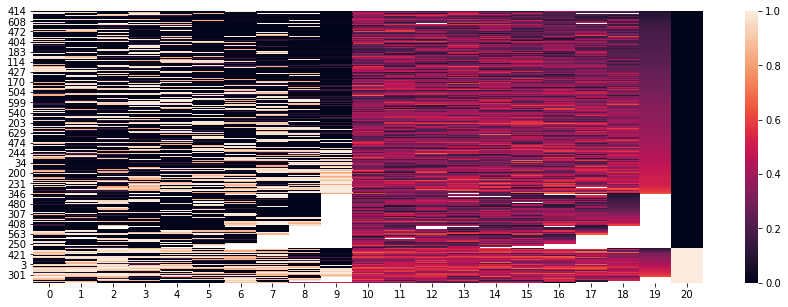

In [17]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 5]

sort_array = [ item for sublist in [ (x, x+10) for x in range(0,10)] for item in sublist ][::-1]
sort_array.insert(0,20)
sns.heatmap(pd.DataFrame(features).sort_values(by=sort_array))

### Preenchimento com média

Atribuímos a cada célula de valor desconhecido o valor médio dos outros elementos da coluna que estão associados a alunos de mesma classificação.

In [18]:

good = pd.DataFrame(features)
bad = pd.DataFrame(features)

good = good[good[20]==1]
bad = bad[bad[20]==0]

def nan_to_mode(table,modes):
    for idx, column in enumerate(table.columns):
        if idx < 10:
            table[column] = table[column].fillna(modes[idx])
        else:
            table[column] = table[column].fillna(table[column].mean())
    return table

modes = good.mode(dropna=True).iloc[0].values.tolist()
good = nan_to_mode(good, modes)
modes = bad.mode(dropna=True).iloc[0].values.tolist()
bad = nan_to_mode(bad, modes)

filled_features = list(good.values.tolist()) + list(bad.values.tolist())

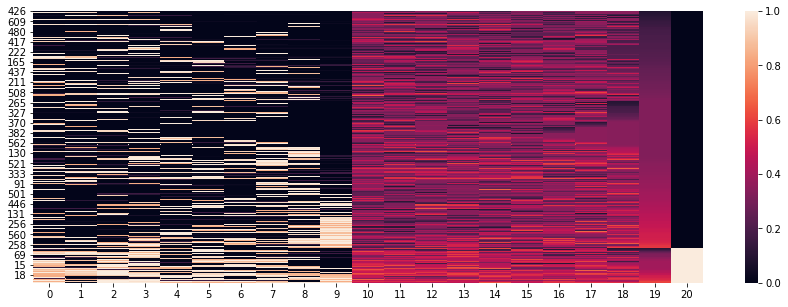

In [19]:
sort_array = [ item for sublist in [ (x, x+10) for x in range(0,10)] for item in sublist ][::-1]
sort_array.insert(0,20)
filled_plot = pd.DataFrame(filled_features)
sns.heatmap(filled_plot.sort_values(by=sort_array))

In [20]:
pd.DataFrame(features).dropna().to_csv('dataset_preenchido.csv', index=False)

### Remoção de ruído

Observando o heatmap, percebemos que em algumas colunas é difícil distinguir os bons alunos dos restantes. Como podem introduzir ruído no dataset, elas serão eliminadas.

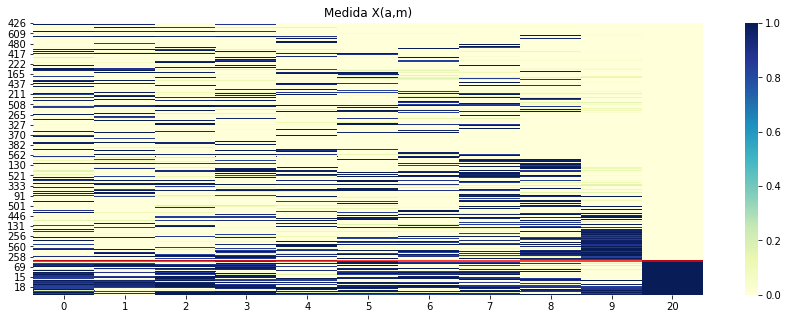

In [21]:
dataplot = pd.DataFrame(filled_features)\
            .dropna()\
            .sort_values(by=sort_array)\
            [[0,1,2,3,4,5,6,7,8,9,20]]

border = dataplot[20].values.tolist()
frontier = [ i for i,v in enumerate(border) if i > 1 and border[i] != border[i-1]][0]

ax = sns.heatmap(dataplot, cmap="YlGnBu")
ax.hlines([frontier], colors=['red'], *ax.get_xlim())
ax.set_title("Medida X(a,m)")
pass

In [22]:
disciplinas['nome_componente'].reset_index()[['nome_componente']]

,nome_componente
0,CÁLCULO 1
1,LÓGICA MATEMÁTICA
2,MATEMÁTICA DISCRETA
3,FÍSICA PARA COMPUTAÇÃO
4,ÁLGEBRA LINEAR
5,CÁLCULO 2
6,PROGRAMAÇÃO DE COMPUTADORES 2 CN
7,SISTEMAS DIGITAIS
8,INTRODUÇÃO À COMPUTAÇÃO
9,PROGRAMAÇÃO DE COMPUTADORES 1 CN


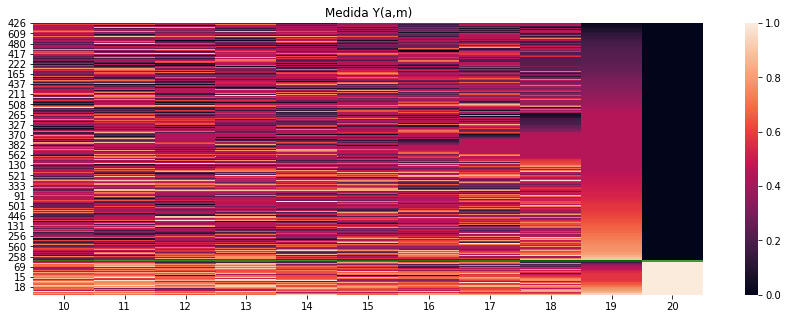

In [23]:
dataplot = pd.DataFrame(filled_features)\
            .dropna()\
            .sort_values(by=sort_array)\
            [[10,11,12,13,14,15,16,17,18,19,20]]

for column in dataplot.columns:
    dataplot[column] = \
    (dataplot[column]-dataplot[column].min())/(dataplot[column].max()-dataplot[column].min())

border = dataplot[20].values.tolist()
border
frontier = [ i for i,v in enumerate(border) if i > 1 and border[i] != border[i-1]][0]

ax = sns.heatmap(dataplot)

ax.hlines([frontier], colors=['green'], *ax.get_xlim())
ax.set_title("Medida Y(a,m)")
pass

In [24]:
legend = disciplinas['nome_componente'].reset_index()[['nome_componente']]
legend.index = legend.index + 10
legend

,nome_componente
10,CÁLCULO 1
11,LÓGICA MATEMÁTICA
12,MATEMÁTICA DISCRETA
13,FÍSICA PARA COMPUTAÇÃO
14,ÁLGEBRA LINEAR
15,CÁLCULO 2
16,PROGRAMAÇÃO DE COMPUTADORES 2 CN
17,SISTEMAS DIGITAIS
18,INTRODUÇÃO À COMPUTAÇÃO
19,PROGRAMAÇÃO DE COMPUTADORES 1 CN


Os heatmaps mostram que as matérias 4 / 14, 6 / 16, 7 / 17, 8 / 18, 19 / 9 ( ÁLGEBRA LINEAR, PROGRAMAÇÃO DE COMPUTADORES 2 CN, SISTEMAS DIGITAIS, INTRODUÇÃO À COMPUTAÇÃO, PROGRAMAÇÃO DE COMPUTADORES 1 CN ) contém lacunas e não permitem diferenciar muito bem entre diferentes regiões da coluna. Estas colunas serão ignoradas.

Quanto às colunas 2 / 12, correspondentes a MATEMÁTICA DISCRETA: na grade nova, ela é equivalente a duas matérias, e a segunda delas não se encontra no primeiro nem no segundo período. 

Portanto, a matéria MATEMÁTICA DISCRETA será considerada apenas para prever resultados de alunos da grade antiga.


Sendo assim, para gerar um modelo válido tanto para a grade nova quanto para a grade antiga, devemos selecionar as colunas 0, 1, 3, 5 ( e 10, 11, 13, 15 ), que correspondem às matérias:

* Cálculo 1  
* Lógica Matemática   
* Física para Computação  
* Cálculo 2

E para dados vindos de alunos da grade nova, devemos renomear suas matérias para as matérias equivalentes consideradas:

* Cálculo 1A : Cálculo 1
* Lógica Matemática  : Lógica Matemática
* Física 1 : Física para Computação  
* Cálculo 2A : Cálculo 2

In [25]:
# Escrever os rows em ordem aleatória
write_dump = lambda x, y, h: x\
.sample(frac=1)\
.to_csv(y, index=False, header=h)

dump = pd.DataFrame(filled_features)[[0,1,3,5,10,11,13,15,20]]
header = [
    '%Cálculo 1',
    '%Lógica',
    '%Física',
    '%Cálculo 2',
    'Cálculo 1',
    'Lógica',
    'Física',
    'Cálculo 2',
    'Classe'
]
write_dump(dump, DATASET_REDUZIDO, header)

In [26]:
dump = pd.DataFrame(filled_features)[[0,1,2,3,5,10,11,12,13,15,20]]
header = [
    '%Cálculo 1',
    '%Lógica',
    '%Matemática Discreta',
    '%Física',
    '%Cálculo 2',
    'Cálculo 1',
    'Lógica',
    'Matemática Discreta',
    'Física',
    'Cálculo 2',
    'Classe'
]
write_dump(dump, DATASET_GRADE_ANTIGA, header)

## Treinamento e Classificação dos dados: Luana Guedes Barros Martins

Obs: Para os códigos abaixo foram utilizados como base a implementação realizada por [Michael Dorner](https://github.com/michaeldorner/DecisionTrees) e [Stanley Luck](https://github.com/lucksd356/DecisionTrees)


### Carregando os dados

A função loadCSV realiza os seguintes passos:
- Lê o dataset .csv gerado na fase de tratamento de dados
- Cria um dicionário enumerando todos os atributos 
- Convert strings que contém números para seus determinados tipos (int/float)

E ao final desses passos, retorna um pandas.DataFrame com a coleção de dados e retorna também o dicionário de atributos que será usado na parte de visualização da árvore gerada.

In [27]:
import csv 
import pandas as pd


def loadCSV(file):
    """ Carrega um arquivo CSV"""
    
    def convertTypes(s):
        """ Converte uma string em dados do tipo int ou float """
        
        s = s.strip() # Função strip retorna uma string sem espaços
        try:
            # se a string for do tipo x.y, onde x e y são números, converte-se a string para um número flutuante
            # se não houver a presença de um .(ponto), então converte-se em um número inteiro
            return float(s) if '.' in s else int(s)
        except ValueError:
            return s

    reader = csv.reader(open(file, 'rt')) # abre arquivo csv

    # next() itera sobre uma lista, no caso, o arquivo csv lido
    # lsHeader irá receber toda a primeira linha do arquivo csv que contém o nome dos atributos
    listHeader = next(reader) 
    header = {}

    # Cria-se um dicionario enumerando todos os atributos 
    # Ex: {'Column 0': 'Atributo0', 'Column 1': 'Atributo1', 'Column 2': 'Atributo2'}
    for it, attribute in enumerate(listHeader):
            column = 'Column %d' % it
            header[column] = str(attribute)

    # Para cada item de cada linha do arquivo csv, converte-se a string para o número associado
    dataset = [[convertTypes(item) for item in row] for row in reader]
    dataset = pd.DataFrame(data=dataset)

    return header, dataset


In [28]:
# Carrega arquivo csv e obtém um dicionario de atributos e os dados de treinamento
headings, dataCSV = loadCSV(DATASET_REDUZIDO)

Para realizar o treinamento e avaliação do mesmo, pegamos o dataset gerado na fase de Tratamento de Dados e dividimos em dois conjuntos de dados: um para treinamento e um para avaliação. Foram escolhidos 20% dos dados para avaliação e 80% para treinamento.

In [29]:
from sklearn.model_selection import train_test_split
import numpy as np


# Separando dados de treinamento e de teste
data = dataCSV.iloc[:, 0:-1].values
results = dataCSV.iloc[:, -1].values
trainingData, testData, trainingResults, testResults = train_test_split(data, results, test_size = 0.2)

training = list(np.c_[trainingData, trainingResults])  # Concatena os dados com seus resultados
evaluation = list(np.c_[testData, testResults])        # Concatena os dados com seus resultados

### Árvore de decisão

Para este trabalho, as perguntas são constituídas de respostas do tipo Verdadeiro ou Falso, criando-se assim uma árvore binária de decisão. As respostas verificam se um atributo particular, do tipo numérico, é maior ou igual a um valor do domínio do atributo, ou se é menor do que o dado valor. A implementação também permite fazer verificações para tipos não numéricos. Nesse último caso, a verificação é dada pela condição de igualdade ou desigualdade entre os valores.

O limiar de separação dos dados, valor que será usado na verificação da condição, é selecionado de forma gulosa com base no atributo que melhor divide o conjunto de dados. Para determinar o quão boa é a condição de teste realizada,  compara-se o grau de entropia do nó antes da divisão e dos nós gerados após a divisão. O atributo que gerar uma maior diferença é escolhido como condição para teste.
Para um conjunto S de exemplos, temos que:

$$Entropia(S) \equiv -p_{\oplus}log_{2}p_{\oplus} - p_{\ominus}log_{2}p_{\ominus}$$

$$Ganho(S,A) \equiv Entropia(S) - \sum\limits_{v\in val(A)}p(A_v)*Entropia(A_v)$$

A árvore é gerada de maneira recursiva partindo-se da raiz (nó que contém todos os dados de treinamento) até que seja atingindo uma condição de parada. Para avaliar essa condição de parada para geração da árvore observa-se se não há mais um ganho de informação significativo com a divisão dos dados, ou seja, se a diferença entre o grau de entropia do nó pai e do grau de entropia dos nós filhos é maior que zero.


Para cada nó da árvore, teremos um conjunto de informações que são descritas abaixo:

In [30]:
class DecisionTree:
    """
    Criação da árvore binária de decisão, com uma ramificação para testes 
    Verdadeiros e uma ramificação para testes Falsos.
    """
    def __init__(self, col=-1, value=None, trueBranch=None, falseBranch=None, results=None, summary=None):
        self.col = col                  # Melhor atributo de divisão do nó 
        self.value = value              # Valor utlizado na comparação
        self.trueBranch = trueBranch    # Ramificação de valores Verdadeiros
        self.falseBranch = falseBranch  # Ramificação de valores Falsos
        self.results = results          # None para nós de decisão
        self.summary = summary          # Entropia e tamanho dos dados


Para auxiliar na construção da árvore foram definidas três funções auxiliares:
- divideSet: Realiza a separação dos atributos dado um valor de comparação. A implementação utilizada permite que seja usado tanto atributos numérios (int/float) quanto atributos do tipo texto. Ao final, será retornando o conjunto de dados divididos em duas partes.
- uniqueCounts: Recebe uma quantidade de dados e calcula a quantidade de cada resultado ali presente. O retorno dessa função consiste em um dicionário contendo os pares resultado-quantidade.
- entropy: cácula o grau de entropia dado a fórmula definida

In [31]:
from math import log

def divideSet(rows, column, value):

    splittingFunction = None

    # Para valores do tipo int ou float
    if isinstance(value, int) or isinstance(value, float): 
        splittingFunction = lambda row : row[column] >= value
    
    # Para valores do tipo string
    else: 
        splittingFunction = lambda row : row[column] == value

    # Dados que atendem uma dada condição 
    list1 = [row for row in rows if splittingFunction(row)]
    # Dados que não atendem uma daa condição
    list2 = [row for row in rows if not splittingFunction(row)]

    return (list1, list2)


def uniqueCounts(rows):
    
    results = {}
    for row in rows:
        # A resposta da classificação estará na última coluna 
        # Cada resposta diz se o aluno é um bom ou mal aluno
        r = row[-1]
        if r not in results: results[r] = 0
        results[r] += 1

    return results


def entropy(rows):

    log2 = lambda x: log(x) / log(2)        # Função para calcular log2(x)
    results = uniqueCounts(rows)            # Pega todos os resultados e sua respectiva quantidade

    entr = 0.0
    for r in results:
        p = float(results[r]) / len(rows)   # Probabilidade de um dado resultado 
        entr -= p * log2(p)                 # Calcula o grau da entropia dado por 

    return entr


A árvore será gerada, como já descrito, através da função growDecisionTree. A função recebe um conjunto de dados de treinamento, e retorna uma árvore binária de decisão, onde cada nó terá a estrutura definida pela classe DecisionTree.

In [32]:
def growDecisionTree(rows):
    """ Gera uma árvore de decisão recursivamente realizando as divisões dos dados dado um atributo de divisão"""

    # Verifica se não há mais dados para serem divididos
    if len(rows) == 0: return DecisionTree()     

    # Realiza o cálculo do grau da entropia do nó pai
    currentScore = entropy(rows)     

    bestGain = 0.0
    bestAttribute = None
    bestSets = None

    # Pega a quantidade de atributos menos a última coluna (coluna de resposta) 
    columnCount = len(rows[0]) - 1              

    for col in range(0, columnCount):
        # Pega todos os valores dos atributos daquele nó
        columnValues = [row[col] for row in rows] 

        # A função set() retorna um conjunto de coleção não ordenada de itens
        # Um conjunto set() é composto por elementos únicos(sem duplicadatas)
        unique = list(set(columnValues))

        # Realiza o teste de escolha de atributo para condição de teste
        for value in unique:
            # Seperação dos dados 
            (set1, set2) = divideSet(rows, col, value)

            p = float(len(set1)) / len(rows)

            # Cálculo do ganho de informação: entropia(pai) - entropia(filhos)
            gain = currentScore - p*entropy(set1) - (1-p)*entropy(set2)

            """ Se o ganho de informação for maior do que já observado
                o atributo em questão se torna o melhor atributo """
            if gain > bestGain and len(set1) > 0 and len(set2) > 0:
                bestGain = gain
                bestAttribute = (col, value)
                bestSets = (set1, set2)

    # Guarda o valor atual da entropia(impureza), e o número de linhas do nó
    summary = {'impurity' : '%.3f' % currentScore, 'samples' : '%d' % len(rows)}

    # Realiza a geração de nós filhos com os melhores sets gerados da divisão
    if bestGain > 0:
        # Ramificação com valores do tipo Verdadeiro
        trueBranch = growDecisionTree(bestSets[0])  

        # Ramificação com valores do tipo Falso
        falseBranch = growDecisionTree(bestSets[1])

        # Armazena o nó pai na árvore
        return DecisionTree(col=bestAttribute[0], value=bestAttribute[1], trueBranch=trueBranch,
                            falseBranch=falseBranch, summary=summary)

    # Se não há ganho de informação, não há mais ramificação desse nó
    else:
        # Armazena o nó folha na árvore os resultados de classificação
        return DecisionTree(results=uniqueCounts(rows), summary=summary)



In [33]:
# Geração da árvore de decisão    
decisionTree = growDecisionTree(training) 

Para visualização da árvore gerada foi utilizado o [pydotplus](https://pypi.org/project/pydotplus/), que é uma interface Python para a linguagem Dot do Graphviz. A função abaixo pega todas as informações de um nó do tipo DecisionTree, transforma em um dicionário de strings em toString, e depois, com esses dados, gera-se um modelo conforme definido no formato DOT. Em pydotplus.graph_from_dot_data, presume-se que os dados estejam no formato DOT, onde será analisado e uma classe Dot será retornada, representando a árvore gerada.


In [34]:
def dotgraph(decisionTree, headings):
    """ Plota a árvore de decisão gerada."""
    
    dcNodes = defaultdict(list)
    def toString(iSplit, decisionTree, bBranch, szParent = "null", indent=''):
        
        if decisionTree.results != None:  # Nó Folha
            
            # Pega todos os possíveis pares de resultados do nó folha
            # Os resultados são do tipo {'classX': quantidade}
            lsX = [(x, y) for x, y in decisionTree.results.items()]
            lsX.sort() # Ordena os resultados
            
            # Para cada par de resultado, organiza em string
            szY = ', '.join(['%s: %s' % (x, y) for x, y in lsX])
            dcY = {"name": szY, "parent" : szParent}
            
            # decisionTree.summary contém a impuridade do nó e a quantidade de samples
            dcSummary = decisionTree.summary
            
            # Adiciona no dicionário que será usado para gerar a visualização da árvore
            dcNodes[iSplit].append(['leaf', dcY['name'], szParent, bBranch, dcSummary['impurity'],
                                    dcSummary['samples']])
            return dcY
        
        else: # Nó de decisão
            
            # Pega a coluna de divisão daquele nó
            szCol = 'Column %s' % decisionTree.col
        
            # Olha se a coluna está no cabeçalho da árvore
            if szCol in headings: szCol = headings[szCol]
                
            # Se a comparação realizada foi do tipo (int/float >= int/float) ou (string==string)
            if isinstance(decisionTree.value, int) or isinstance(decisionTree.value, float):
                if szCol[0] == '%':
                    decision = '%s >= %s' % (szCol, round(decisionTree.value, 4))
                else:
                    decision = '%s >= %s' % (szCol, round((decisionTree.value * 20) - 10, 4))
            else:
                decision = '%s == %s' % (szCol, round(decisionTree.value, 4))
                    
            # Transforma os dados em string
            trueBranch = toString(iSplit+1, decisionTree.trueBranch, True, decision, indent + '\t\t')
            falseBranch = toString(iSplit+1, decisionTree.falseBranch, False, decision, indent + '\t\t')
            
            # decisionTree.summary contém a impuridade do nó e a quantidade de samples 
            dcSummary = decisionTree.summary
            
            # Adiciona no dicionário que será usado para gerar a visualização da árvore
            dcNodes[iSplit].append([iSplit+1, decision, szParent, bBranch, dcSummary['impurity'],
                                    dcSummary['samples']])
            return

    # Gera o dicionário de texto com as informações da árvore
    toString(0, decisionTree, None)
    
    # Definições visuais da árvore (shape, style, color, font, ...) 
    lsDot = ['digraph Tree {',
                'node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;',
                'edge [fontname=helvetica] ;'
            ]

    
    # Para cada entrada do dicionário gerado gera um modelo conforme formato DOT
    i_node = 0
    dcParent = {}
    for nSplit in range(len(dcNodes)):
        lsY = dcNodes[nSplit]
        for lsX in lsY:
            iSplit, decision, szParent, bBranch, szImpurity, szSamples =lsX
            if type(iSplit) == int:
                szSplit = '%d-%s' % (iSplit, decision)
                dcParent[szSplit] = i_node
                lsDot.append('%d [label=<%s<br/>impurity %s<br/>samples %s>, fillcolor="#e5813900"] ;' % (i_node,
                                        decision.replace('>=', '&ge;').replace('?', ''),
                                        szImpurity,
                                        szSamples))
            else:
                if float(szImpurity) > 0:
                    lsDot.append('%d [label=<impurity %s<br/>samples %s<br/>class %s>, fillcolor="#FF6347"] ;' % (i_node,
                                            szImpurity,
                                            szSamples,
                                            decision))
                else:
                    lsDot.append('%d [label=<impurity %s<br/>samples %s<br/>class %s>, fillcolor="#98FB98"] ;' % (i_node,
                                            szImpurity,
                                            szSamples,
                                            decision))
                
            if szParent != 'null':
                if bBranch:
                    szAngle = '45'
                    szHeadLabel = 'True'
                else:
                    szAngle = '-45'
                    szHeadLabel = 'False'
                szSplit = '%d-%s' % (nSplit, szParent)
                p_node = dcParent[szSplit]
                if nSplit == 1:
                    lsDot.append('%d -> %d [labeldistance=2.5, labelangle=%s, headlabel="%s"] ;' % (p_node,
                                                        i_node, szAngle, szHeadLabel))
                else:
                    lsDot.append('%d -> %d ;' % (p_node, i_node))
            i_node += 1
    lsDot.append('}')
    dot_data = '\n'.join(lsDot)
    
    # Retorna o modelo DOT formatado 
    return dot_data


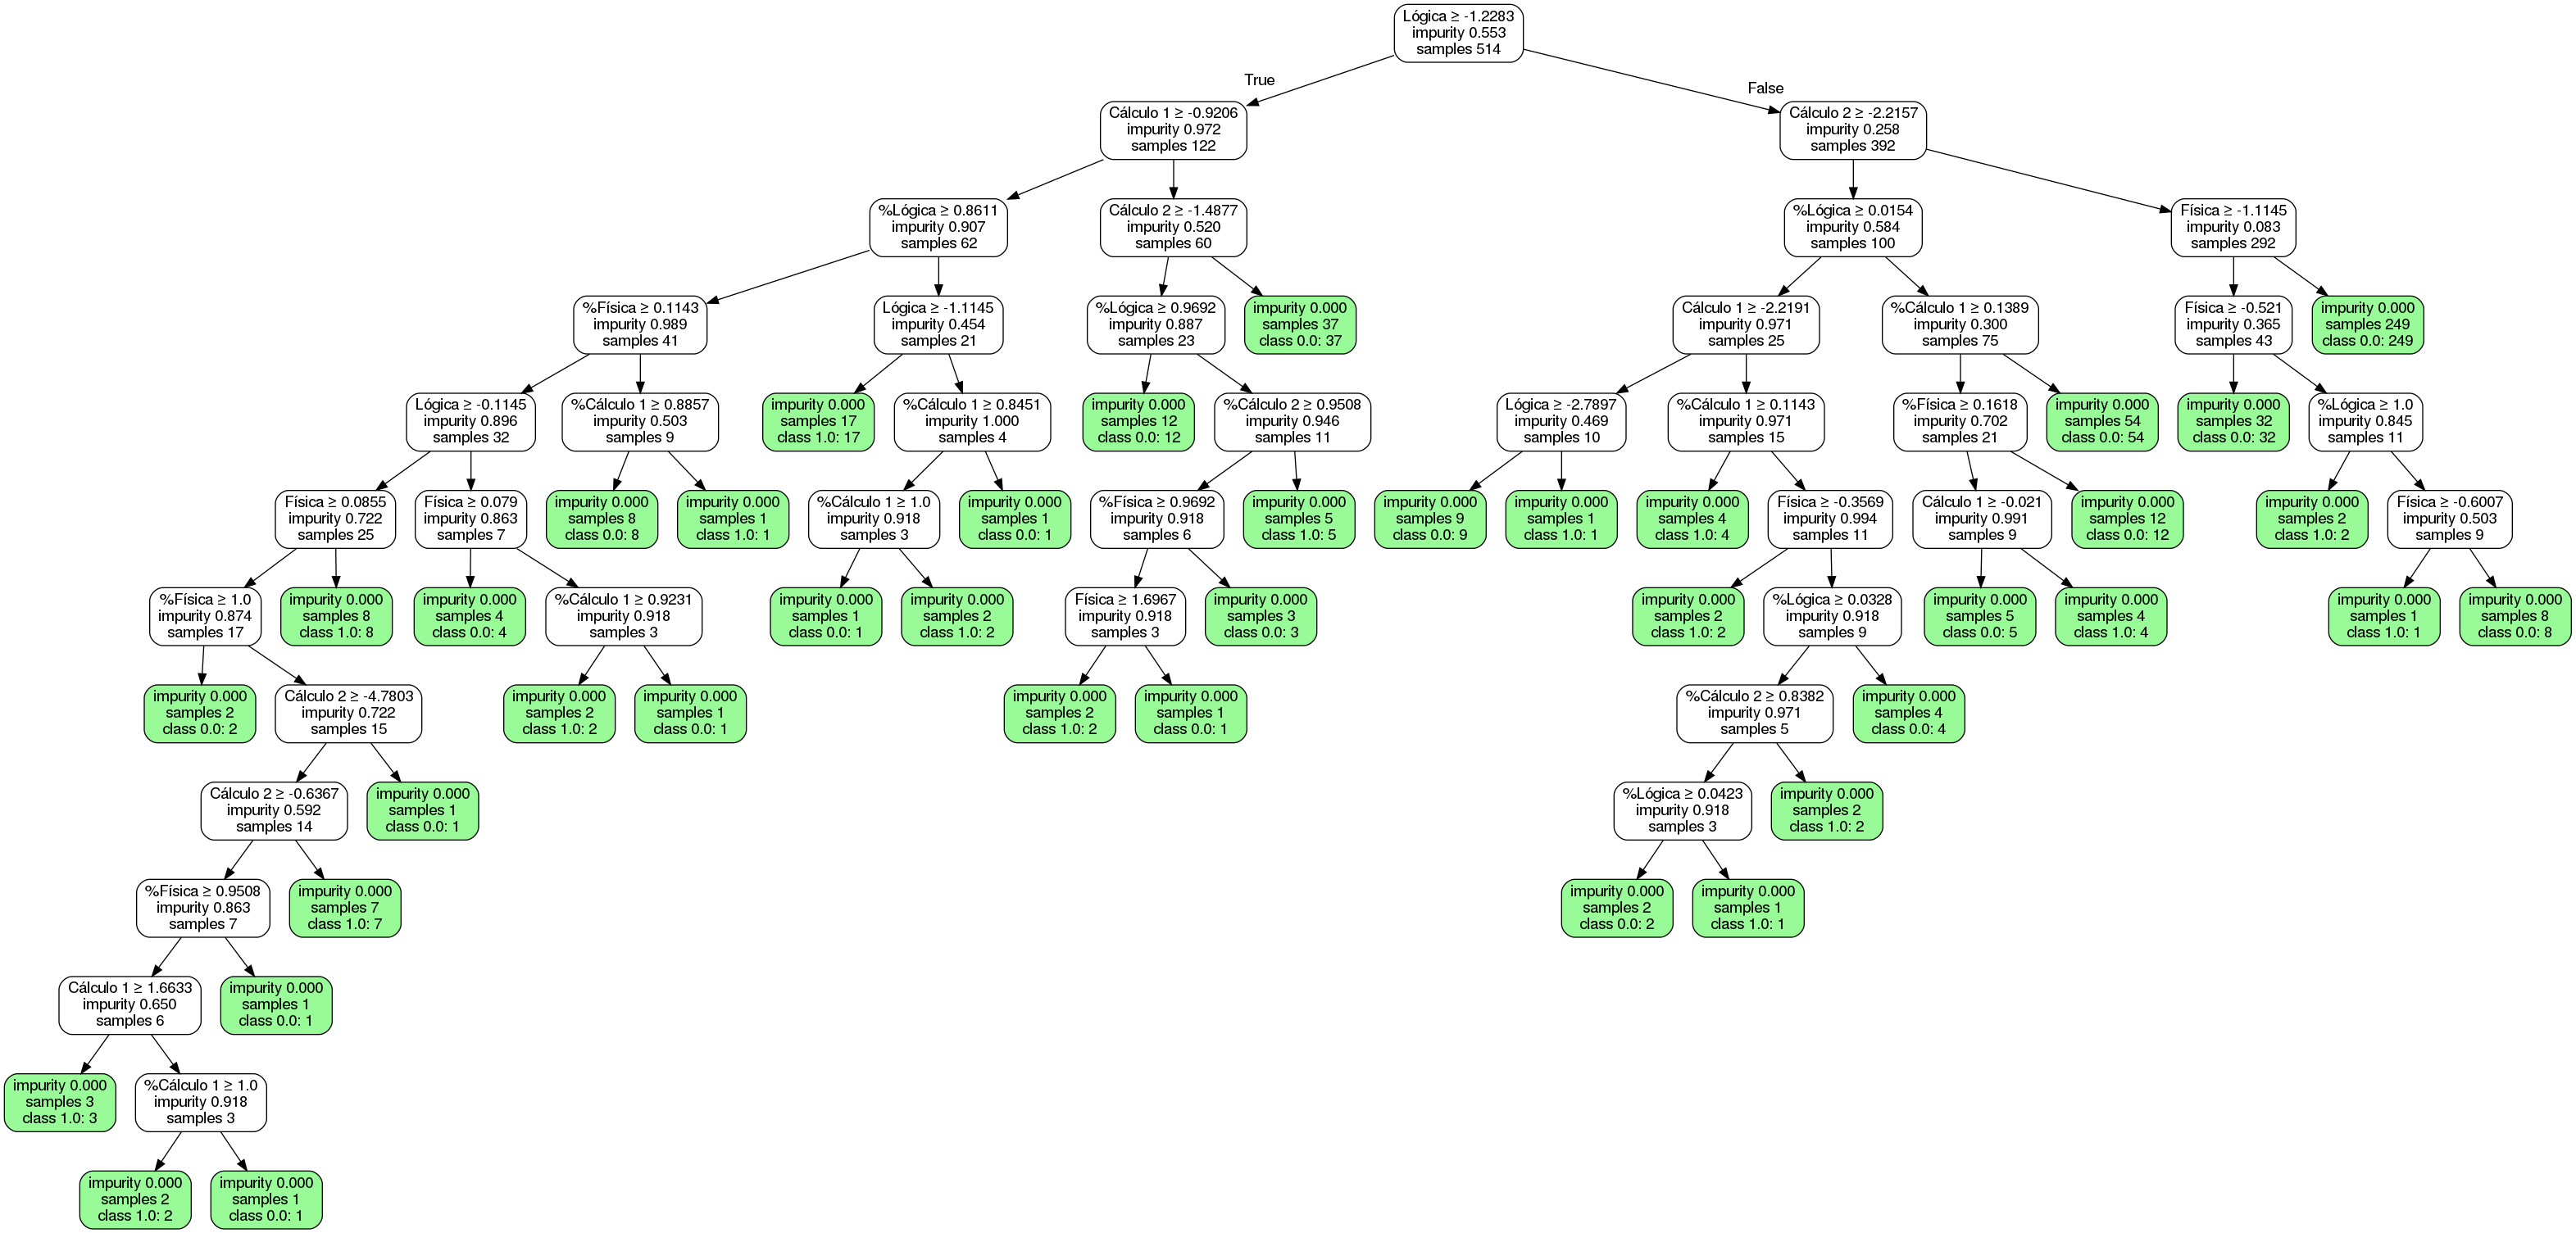

In [35]:
# Gera um dicionário que será utilizado na geração da visualização
dot_data = dotgraph(decisionTree, headings)

# Gera a visualização com o dicionário gerado
graph = pydotplus.graph_from_dot_data(dot_data)

# Salva em a imagem
graph.write_png("arvore_sem_poda.png")

# Mostra a árvore de decisão gerada *sem* a poda
display(Image(filename = 'arvore_sem_poda.png'))

#### Poda da árvore

A poda da árvore é realizada após a geração da mesma. Para tal, é realizado uma busca na árvore, de baixo para cima, onde aqueles ramos que não apresentam nenhum ganho significativo são transformados em nós folhas. Para cada no interno calcula-se a taxa de erro caso não haja a poda, e, em seguida, calcula-se a taca de erro caso não haja a poda. Se a diferença entre essas duas taxas de erro for menor que um valor pré-estabelecido, a árvore é podada.

In [36]:
def prune(tree, minGain):
    """ Realiza a poda da árvore de acordo com um valor mínimo estabelecido."""

    # Olha se os filhos de um nó são folhas(resultado). Se None não é.
    if tree.trueBranch.results == None: 
        prune(tree.trueBranch, minGain)

    if tree.falseBranch.results == None: 
        prune(tree.falseBranch, minGain)

    
    if tree.trueBranch.results != None and tree.falseBranch.results != None:
        trueBranch, falseBranch = [], []

        # Pega os resultados dos nós folhas
        # v = resultado, c = quantidade daquele resultado
        for v, c in tree.trueBranch.results.items(): trueBranch += [[v]] * c
        for v, c in tree.falseBranch.results.items(): falseBranch += [[v]] * c

        p = float(len(trueBranch)) / len(trueBranch + falseBranch)

        # Calcula a diferença das taxas de erro
        delta = entropy(trueBranch + falseBranch) - p * entropy(trueBranch) - (1 - p) * entropy(falseBranch)
        
        # Realiza a poda da árvore caso a diferença das taxas seja menor que minGain
        if delta < minGain:
            # Desconsidera-se os nós filhos desse nó
            tree.trueBranch, tree.falseBranch = None, None
            tree.results = uniqueCounts(trueBranch + falseBranch)


In [37]:
# Poda da árvore (método de pós-poda) 
prune(decisionTree, MIN_GAIN)                       

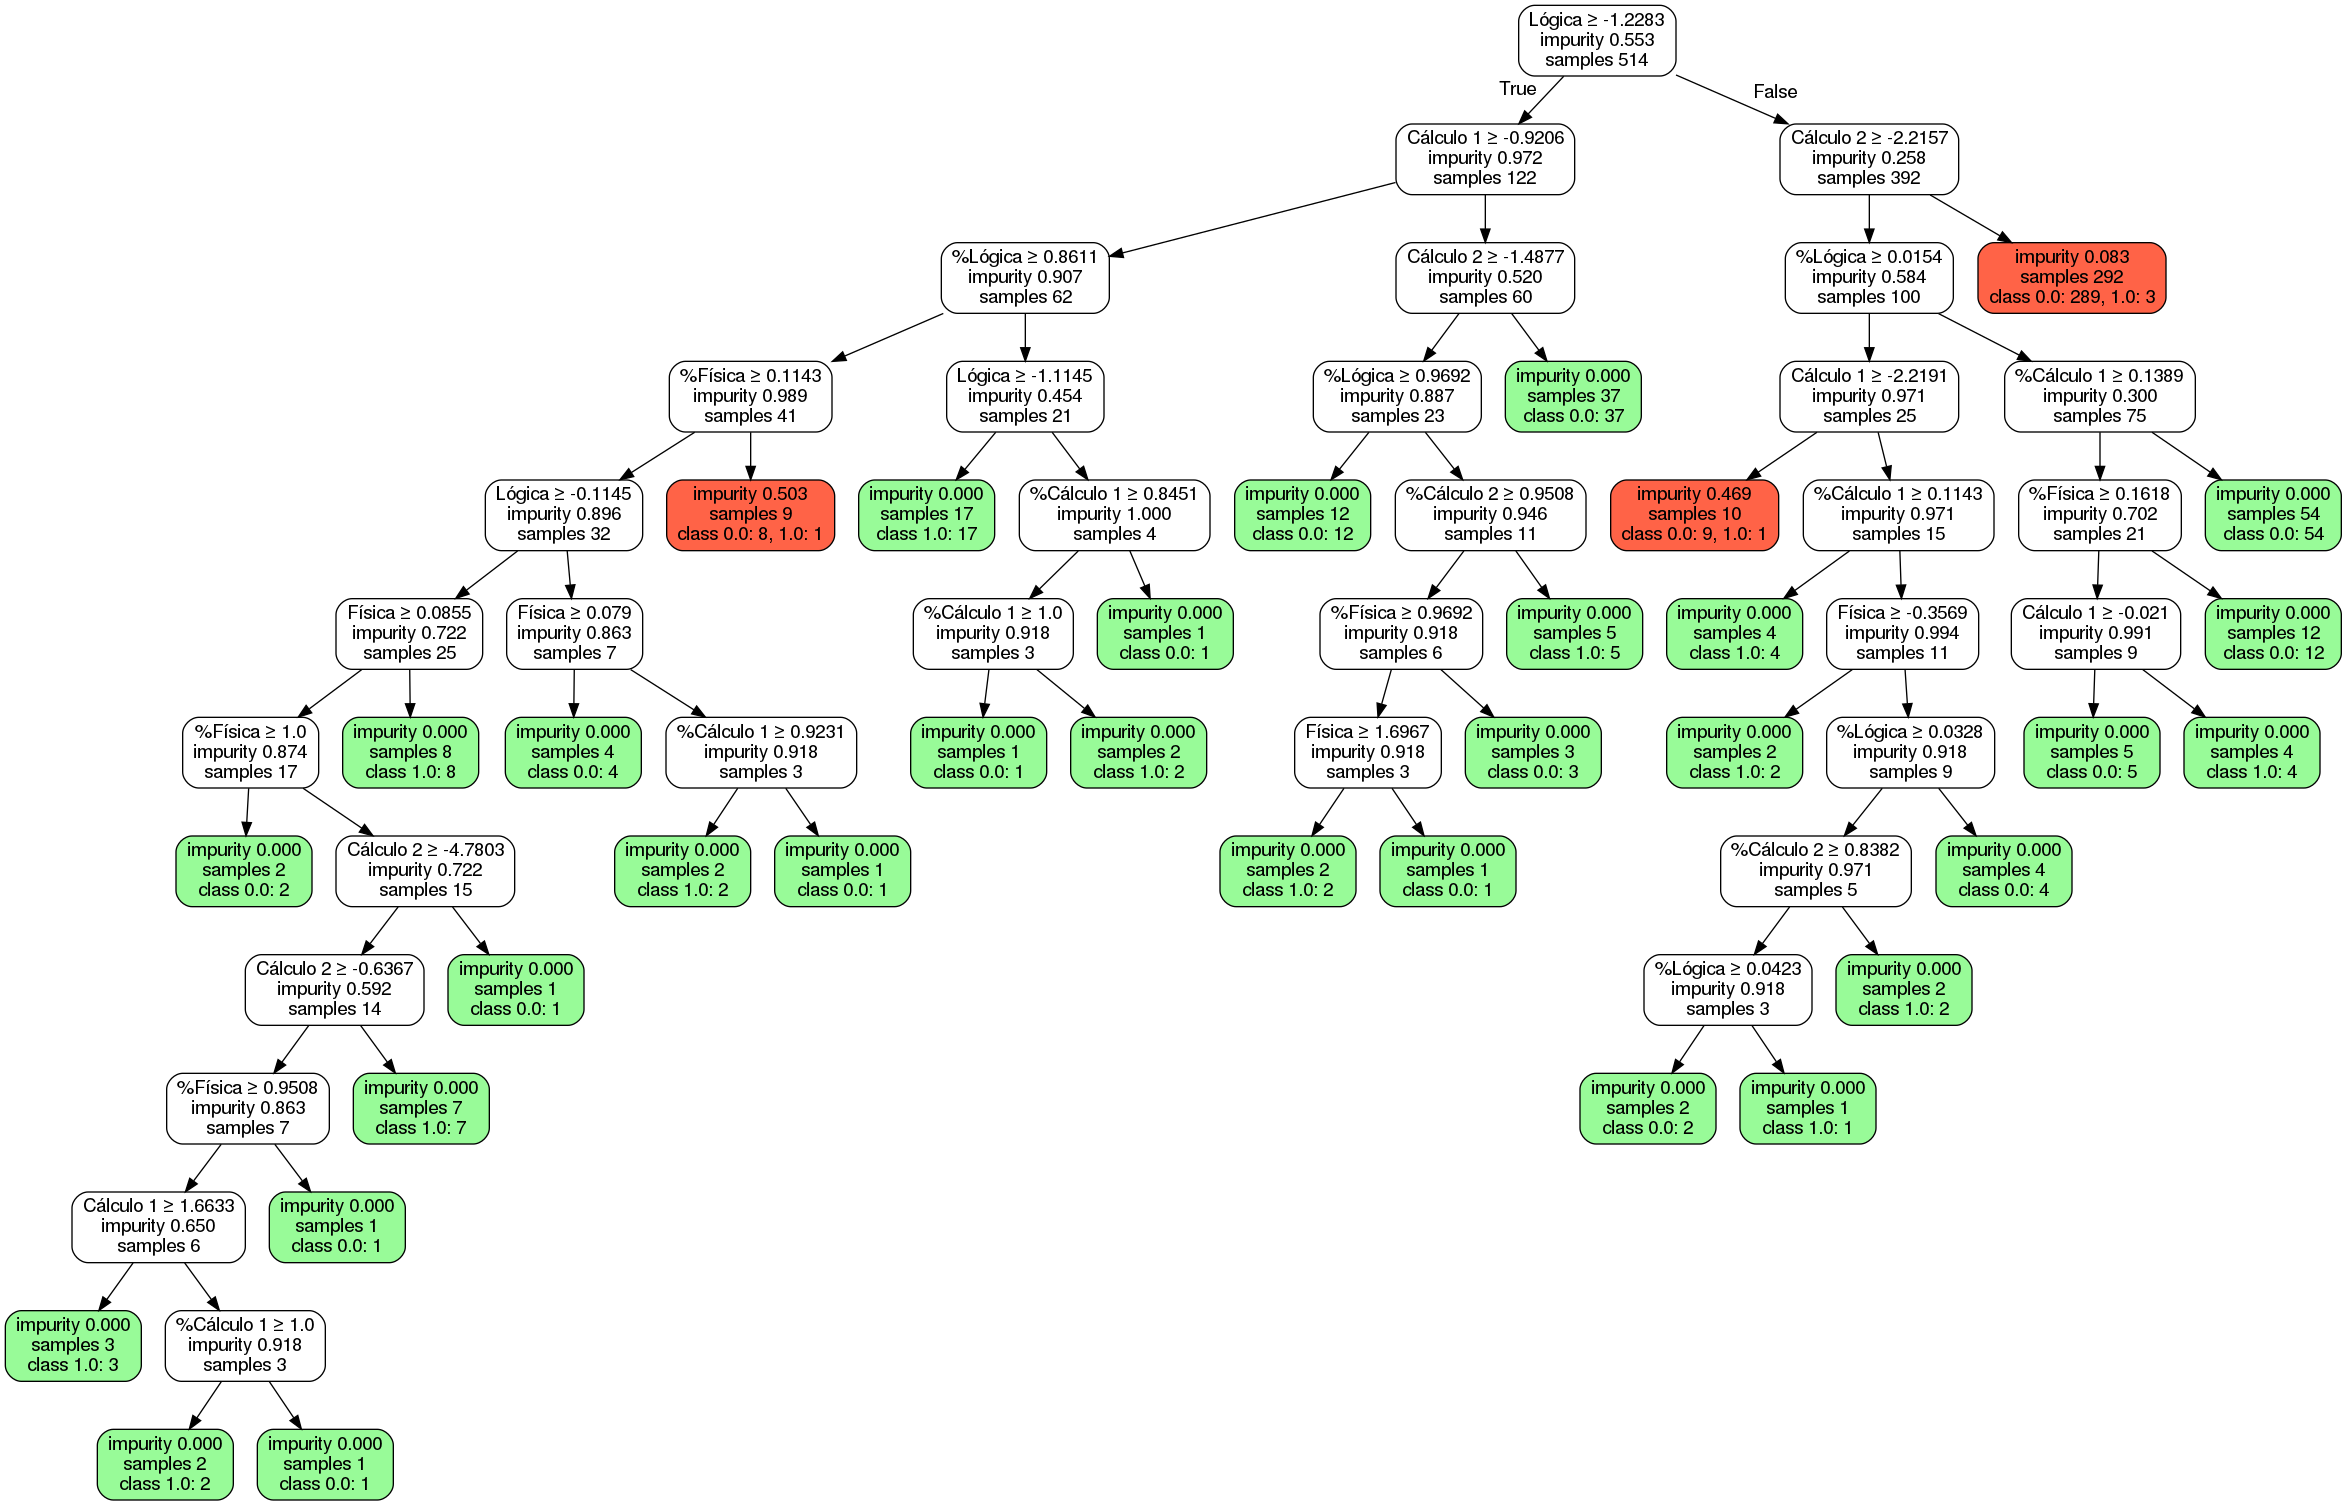

In [38]:
# Gera a visualização da árvore usando Graphviz
dot_data = dotgraph(decisionTree, headings)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("arvore_com_poda.png")

# Mostra a árvore de decisão gerada *com* a poda
display(Image(filename = 'arvore_com_poda.png'))

### Resultado
Depois de gerada a árvore de decisão com os dados de treinamento, e realizado a poda, realizamos a classificação dos dados de teste. 

A função abaixo classifica dados com base na árvore de decisão gerada. É possível realizar a classificação de dados conhecidos e não conhecidos (sem e com dados faltantes). 

Para realizar a classificação com dados não conhecidos associa-se uma probabilidade a cada um dos possíveis valores do atributo. As probabilidades são estimadas pela frequência dos valores para o atributo nos exemplos do nó daquele atributo. Com esses valores, calcula-se o ganho de informação desse atributo. Para cada ramo em que que o valor do atributo desconhecido foi visto, calcula-se um peso para a classe. A saída final será um dicionário contendo todas as possíveis classes com seus determinados pesos.

Se for realizado um teste de acurácia, é necessário ter conhecimento prévio dos resultados das observações, para ser possível medir a taxa de acerto. Nesse modo a função retorna dois valores: 
- Um dicionário com informações de acurácia, número de acertos e erros.
- Uma lista com os valores obtidos na classificação. Essa lista deverá ser usada para construção de uma matriz de confusão

Se não for um teste de acurácia, então será obtido uma lista de classificações das observações dadas.

In [39]:
def classify(observations, tree, dataMissing=False, accuracyTest=True):
    """
    Classifica as observações de acordo com a árvore de classificação gerada.
    
    Para accuracyTest == True, será retornado:
    - Um dicionário com informações de acurácia, número de acertos e erros.
    - Uma lista com os valores obtidos na classificação. 
    
    Para accuracyTest == False, será retornado:
    - Uma lista de classificações das observações dadas.
    
    Args:
        observation (list): observação a ser avaliada
        tree (DecisionTree): árvore de decisão gerada
        dataMissing (bool): True ou False se tiver dados faltando ou não
        accuracyTest (bool): True para realizar um teste de acurácia
    """

    def classifyWithoutMissingData(observations, tree):
        """ Classificação das observações que não possuem dados faltantes"""

        if tree.results != None:  # Nó folha que contém a classificação 
            return tree.results
        else:                     # Nó de decisão

            # Valor da observação correspondente ao atributo de divisão do nó 
            v = observations[tree.col]
            branch = None

            # Para valores do tipo int ou float
            if isinstance(v, int) or isinstance(v, float):
                """
                Se o valor da observação for maior ou igual ao valor de corte 
                daquele nó desce para a ramificação de valores verdadeiros.
                Se não, desce para a outra ramificação desse nó.
                """
                if v >= tree.value: branch = tree.trueBranch
                else: branch = tree.falseBranch

            # Para valores do tipo string
            else:
                """
                Se o valor da observação for igual ao valor de corte daquele nó
                desce para a ramificação de valores verdadeiros. 
                Se não, desce para a outra ramificação desse nó.
                """
                if v == tree.value: branch = tree.trueBranch
                else: branch = tree.falseBranch

        # Desce recursivamente na árvore
        return classifyWithoutMissingData(observations, branch)


    def classifyWithMissingData(observations, tree):
        """  Classificação das observações que possuem dados faltantes. """

        if tree.results != None:    # Nó folha com o resultado
            return tree.results
        else:                       # Nó de decisão
    
            # Valor da observação correspondente ao atributo de divisão do nó 
            v = observations[tree.col]
            if v == None:
                
                # Passa o exemplo com valor desconhecido para as ramificações do nó atual
                tr = classifyWithMissingData(observations, tree.trueBranch)
                fr = classifyWithMissingData(observations, tree.falseBranch)
                
                tcount = sum(tr.values())  
                fcount = sum(fr.values()) 
                
                # Cálculo da probabilidade com base na frequência observada dos valores para o atributo
                tw = float(tcount)/(tcount + fcount)
                fw = float(fcount)/(tcount + fcount)
                
                # defaultdict permite que seja criado um dicionario com valores padrões para as chaves
                result = defaultdict(int) 
                
                # Cálculo do 'voto' para cada classe
                for k, v in tr.items(): result[k] += v * tw
                for k, v in fr.items(): result[k] += v * fw
            
            else: # Realiza o mesmo processo de classifyWithoutMissingData()
                branch = None
                if isinstance(v, int) or isinstance(v, float):
                    if v >= tree.value: branch = tree.trueBranch
                    else: branch = tree.falseBranch
                else:
                    if v == tree.value: branch = tree.trueBranch
                    else: branch = tree.falseBranch

            # Desce recursivamente na árvore
            return classifyWithMissingData(observations, branch)


    """
    Seleciona a função de classificação de acordo com dataMissing

    As funções de classifyWithMissingData e classifyWithoutMissingData, 
    retornam um dicionário com a classificação daquele nó mais a quantidade
    daquele resultado do nó. Se um nó tiver mais de uma classificação, será 
    considerado o resultado com a maior quantidade.

    - Se for realizado um teste de acurácia o resultado obtido da classificação
    será comparado com o valor do resultado previamente dado. Um dicionário 
    será retornado com a quantidade de acertos, erros, e a acurária.
    - Se for realizado uma obtenção de classificação, retorna-se uma lista com
    todas as classificações das observações dadas.
    """
    
    def accuracy (observations, classifyData):
        """Realiza um teste de acurácia sobre os dados de teste."""
        predict = []
        
        trueClassify = 0
        falseClassify = 0
        
        for row in observations:
            
            # Obtém-se o valor da classificação
            value = classifyData(row[0:-1], tree) 

            # Caso aquele nó seja impuro, possui mais de uma classificação
            if len(value) > 1:
                if value[0.0] > value[1.0]:
                    if value[0.0] - value[1.0] > MARGEM_DE_ERRO:
                        result = 0
                    else:
                        result = 1
            else:
                result = int(list(value)[0])

            # Adiciona o resultado obtido a uma lista de resultados
            predict.append(float(result))
            
            # Incremento de classificações verdadeiras ou falsas
            if result == row[-1]: trueClassify += 1
            else: falseClassify += 1
                
                
        output = {
                    'Acertos': trueClassify, 
                    'Erros': falseClassify, 
                    'Acurácia': float(round(float(trueClassify)/len(observations), 4))
                }
                
        return output, predict
                
    def prediction (observations, classifyData):
        """Realiza a predição de dados sem conhecimento de seus resultados."""
        
        predict = []
        n = 1
        for row in observations:
            
            # Obtém-se o valor de classificação
            value = classifyData(row, tree)

            # Caso aquele nó possui mais de uma classificação
            if len(value) > 1:
                if value[0.0] > value[1.0]:
                    if value[0.0] - value[1.0] > MARGEM_DE_ERRO:
                        r = 0
                    else:
                        r = 1
            else:
                r = int(list(value)[0])

            result = 'Aluno com desempenho satisfatório' if r else 'Aluno com desempenho não satisfatório'
            
            # Adiciona o resultado obtido a uma lista de resultados
            predict.append(str(n) + 'ª Classificação: ' + result)
            n += 1
            
        return predict
        

    if dataMissing: # Se tiver dados faltantes no conjunto de observação
        if not accuracyTest: # Se for para obter a classificação de um cojunto
            return prediction(observations, classifyWithMissingData)

        else:
            return accuracy(observations, classifyWithMissingData)

    else: # Se não tiver dados faltantes no conjunto de observação
        if not accuracyTest: # Se for para obter a classificação de um cojunto
            return prediction(observations, classifyWithoutMissingData)

        else: # Se for um teste de acurácia
            return accuracy(observations, classifyWithoutMissingData)
            

In [40]:
# Realiza teste de acurácia com os dados de teste
accuracy, predict = classify(evaluation, decisionTree, accuracyTest=True)
accuracy

{'Acertos': 111, 'Erros': 18, 'Acurácia': 0.8605}

In [41]:
# Realiza a classificação com dados sem o resultado conhecido
classification = classify(list(testData)[0:10], decisionTree, accuracyTest=False)
for c in classification: print(c)

1ª Classificação: Aluno com desempenho não satisfatório
2ª Classificação: Aluno com desempenho não satisfatório
3ª Classificação: Aluno com desempenho não satisfatório
4ª Classificação: Aluno com desempenho não satisfatório
5ª Classificação: Aluno com desempenho não satisfatório
6ª Classificação: Aluno com desempenho não satisfatório
7ª Classificação: Aluno com desempenho não satisfatório
8ª Classificação: Aluno com desempenho não satisfatório
9ª Classificação: Aluno com desempenho não satisfatório
10ª Classificação: Aluno com desempenho não satisfatório


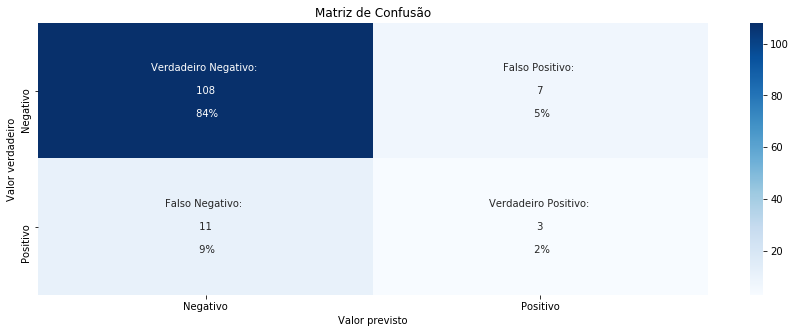

In [42]:
# Construindo a Matriz de Confusão
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(list(np.array(evaluation)[...,-1]), predict) 
ax = sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues')
ax.set(ylabel='Valor verdadeiro')
ax.set(xlabel='Valor previsto')
labels = ['Verdadeiro Negativo', 
          'Falso Positivo', 
          'Falso Negativo', 
          'Verdadeiro Positivo']
ax.set(yticklabels=['Negativo','Positivo'])
ax.set(xticklabels=['Negativo','Positivo'])
count = 0
bacc = []
for idx, text in enumerate(ax.texts):
    label = int(text.get_text())
    count += label
    bacc.append(label)

acc1 = bacc[0] / ( bacc[0] + bacc[2] )
acc2 = bacc[3] / ( bacc[1] + bacc[3] ) 
balanced_accuracy = ( acc1 + acc2 ) / 2
for idx,text in enumerate(ax.texts):
    square = text.get_text()
    percent = int(text.get_text()) / count
    percent = "{0:.0%}".format(percent)
    box_text = "{0}: \n \n {1} \n \n {2}".format(labels[idx], square, percent)
    text.set_text(box_text)
ax.set_title('Matriz de Confusão')
pass

Observemos a acurácia da primeira e da segunda coluna da matriz de confusão separadamente, bem como a média de ambas ( acurácia equilibrada )

In [43]:
print("Acc1: {0} \n \n Acc2: {1} \n \n Acurácia Equilibrada: {2}".format(
    acc1,
    acc2,
    balanced_accuracy))

Acc1: 0.907563025210084 
 
 Acc2: 0.3 
 
 Acurácia Equilibrada: 0.603781512605042


# Benchmarks

A função train_test_split() do sklearn, produz subconjuntos de dados para teste e treinamento de maneira pseudo-randômica. Portanto, para os testes, foram realizados um total 186 testes com os datasets disponíveis:

- dataset_reduzido.csv: dataset sem a matéria Matemática Discreta ( 80 testes )
- dataset_reduzido_grade_antiga.csv: dataset com a matéria Matemática Discreta ( 106 testes )

Foi obtida uma acurácia total de 88% para dataset_reduzido.csv, e de 89% para dataset_reduzido_grade_antiga.csv .

O modelo foi capaz de distinguir entre verdadeiro e falso positivo com 51% de acurácia para dataset_reduzido.csv, e 56% de acurácia para dataset_reduzido_grade_antiga.csv .


In [44]:
lst = [{"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.23076923076923078, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.585212201591512}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9203539823008849, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7726769911504425}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8956521739130435, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6978260869565218}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9145299145299145, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7072649572649572}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7359649122807017}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9344262295081968, "Acur\u00e1cia 2": 0.8571428571428571, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8957845433255269}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9130434782608695, "Acur\u00e1cia 2": 0.42857142857142855, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.670807453416149}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.746583850931677}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9572649572649573, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.811965811965812}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.911504424778761, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7370022123893805}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7261273209549072}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9047619047619048, "Acur\u00e1cia 2": 0.4583333333333333, "Acur\u00e1cia Total": 0.8217, "Acur\u00e1cia Equilibrada": 0.6815476190476191}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7584033613445378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.963963963963964, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7319819819819819}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9401709401709402, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8450854700854701}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.918918918918919, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7927927927927928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9663865546218487, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7331932773109244}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7195652173913043}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.954954954954955, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8108108108108107}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7785285285285286}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6621352785145889}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9416666666666667, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8041666666666667}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9649122807017544, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7491228070175439}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9375, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7334558823529411}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8898305084745762, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7630970724191063}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6228070175438596}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8991596638655462, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7495798319327731}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9473684210526315, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7070175438596491}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9576271186440678, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7515408320493067}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8888888888888888, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6527777777777778}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9351851851851852, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7533068783068784}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.722972972972973}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9, "Acur\u00e1cia 2": 0.47368421052631576, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6868421052631579}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9327731092436975, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.6663865546218488}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9473684210526315, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8070175438596491}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7502765486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9130434782608695, "Acur\u00e1cia 2": 0.21428571428571427, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.5636645962732919}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7390583554376657}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7800462249614792}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.42105263157894735, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.687799043062201}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6906906906906907}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9238095238095239, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.8295, "Acur\u00e1cia Equilibrada": 0.6702380952380953}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9051724137931034, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.721816976127321}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9469026548672567, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7547013274336283}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9819819819819819, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7965465465465466}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9732142857142857, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7219012605042017}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8306197478991597}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7271929824561403}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9557522123893806, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7278761061946903}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.722972972972973}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.631578947368421, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7930622009569378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9401709401709402, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7617521367521367}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9173553719008265, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7711776859504132}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9098360655737705, "Acur\u00e1cia 2": 0.2857142857142857, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.5977751756440282}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7842835130970724}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9411764705882353, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7705882352941176}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.746583850931677}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9181818181818182, "Acur\u00e1cia 2": 0.42105263157894735, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6696172248803828}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9655172413793104, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7519893899204244}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9565217391304348, "Acur\u00e1cia 2": 0.7142857142857143, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8354037267080745}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8879310344827587, "Acur\u00e1cia 2": 0.6923076923076923, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7901193633952255}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9491525423728814, "Acur\u00e1cia 2": 0.9090909090909091, "Acur\u00e1cia Total": 0.9457, "Acur\u00e1cia Equilibrada": 0.9291217257318952}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8907563025210085, "Acur\u00e1cia 2": 0.8, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.8453781512605043}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.864, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6819999999999999}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.5789473684210527, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7667464114832536}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9180327868852459, "Acur\u00e1cia 2": 0.7142857142857143, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8161592505854801}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.954954954954955, "Acur\u00e1cia 2": 0.5555555555555556, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7552552552552553}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9304347826086956, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7866459627329192}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9469026548672567, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7859513274336283}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.6153846153846154, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7688992042440319}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8861788617886179, "Acur\u00e1cia 2": 0.16666666666666666, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.5264227642276423}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7948717948717949}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7815265486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8306197478991597}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.907563025210084, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.753781512605042}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9642857142857143, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.717436974789916}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9439252336448598, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7446898895497026}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6805555555555556}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.4117647058823529, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6567752100840336}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9568965517241379, "Acur\u00e1cia 2": 0.6153846153846154, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7861405835543767}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9663865546218487, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.9457, "Acur\u00e1cia Equilibrada": 0.8331932773109243}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.6923076923076923, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.8073607427055702}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9181818181818182, "Acur\u00e1cia 2": 0.47368421052631576, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.695933014354067}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6919761273209549}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.4375, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6877765486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9363636363636364, "Acur\u00e1cia 2": 0.7368421052631579, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8366028708133971}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6964285714285714}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9636363636363636, "Acur\u00e1cia 2": 0.5263157894736842, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.744976076555024}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.36363636363636365, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.647919876733436}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9428571428571428, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6797619047619048}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9196428571428571, "Acur\u00e1cia 2": 0.6470588235294118, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7833508403361344}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7184684684684685}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.35714285714285715, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6394409937888199}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7388289676425269}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.941747572815534, "Acur\u00e1cia 2": 0.5769230769230769, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7593353248693054}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.8571428571428571, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8981366459627329}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8813559322033898, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7134052388289676}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.957983193277311, "Acur\u00e1cia 2": 0.3, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.6289915966386554}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9711538461538461, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7855769230769231}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7423844537815126}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7359649122807017}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9304347826086956, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7509316770186335}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7450105042016807}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9067796610169492, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7715716486902928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.2, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.5605263157894737}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9292035398230089, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7771017699115044}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6517543859649123}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9557522123893806, "Acur\u00e1cia 2": 0.8125, "Acur\u00e1cia Total": 0.938, "Acur\u00e1cia Equilibrada": 0.8841261061946903}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9243697478991597, "Acur\u00e1cia 2": 0.8, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8621848739495799}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9586776859504132, "Acur\u00e1cia 2": 0.375, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.6668388429752066}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9316239316239316, "Acur\u00e1cia 2": 0.25, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.5908119658119658}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7026315789473685}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9193548387096774, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.6596774193548387}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9586776859504132, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7293388429752066}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8974358974358975, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.657051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6492042440318303}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9464285714285714, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7379201680672269}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9487179487179487, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.766025641025641}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.45454545454545453, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6891371340523883}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9724770642201835, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7612385321100918}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9203539823008849, "Acur\u00e1cia 2": 0.375, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6476769911504425}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6876657824933687}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7345916795069337}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.774024024024024}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6951951951951951}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6964285714285714}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6271929824561403}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9743589743589743, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9535, "Acur\u00e1cia Equilibrada": 0.8621794871794872}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8771929824561403, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8295, "Acur\u00e1cia Equilibrada": 0.6719298245614035}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9739130434782609, "Acur\u00e1cia 2": 0.35714285714285715, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.665527950310559}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8918918918918919, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7515015015015015}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9333333333333333, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9357798165137615, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6678899082568808}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8974358974358975, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.782051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7129726890756303}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9067796610169492, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7715716486902928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9259259259259259, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.701058201058201}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8771929824561403, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7719298245614035}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8803418803418803, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7735042735042734}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9083333333333333, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6763888888888889}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9351851851851852, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7056878306878307}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.940677966101695, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7885208012326657}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.956140350877193, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7780701754385965}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.944954128440367, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7224770642201834}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9026548672566371, "Acur\u00e1cia 2": 0.6875, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7950774336283186}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9568965517241379, "Acur\u00e1cia 2": 0.7692307692307693, "Acur\u00e1cia Total": 0.938, "Acur\u00e1cia Equilibrada": 0.8630636604774535}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9310344827586207, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6962864721485411}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.4117647058823529, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6701680672268908}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9646017699115044, "Acur\u00e1cia 2": 0.4375, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7010508849557522}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8898305084745762, "Acur\u00e1cia 2": 0.8181818181818182, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.8540061633281972}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9541284403669725, "Acur\u00e1cia 2": 0.45, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7020642201834862}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.29411764705882354, "Acur\u00e1cia Total": 0.8217, "Acur\u00e1cia Equilibrada": 0.5979516806722689}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.944954128440367, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7474770642201836}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6396396396396397}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9279279279279279, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7139639639639639}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7115384615384616}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8918918918918919, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7515015015015015}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.42857142857142855, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6751552795031056}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9292035398230089, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7146017699115044}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.918918918918919, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7094594594594594}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9243697478991597, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8121848739495798}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9439252336448598, "Acur\u00e1cia 2": 0.5909090909090909, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7674171622769754}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7584033613445378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7423844537815126}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9482758620689655, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7049071618037135}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7304376657824934}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7532051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9298245614035088, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7315789473684211}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9611650485436893, "Acur\u00e1cia 2": 0.34615384615384615, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6536594473487678}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9649122807017544, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7491228070175439}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9791666666666666, "Acur\u00e1cia 2": 0.45454545454545453, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.7168560606060606}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6850877192982456}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9375, "Acur\u00e1cia 2": 0.35294117647058826, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6452205882352942}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9174311926605505, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7337155963302753}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6517543859649123}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9541284403669725, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8270642201834862}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9421487603305785, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8460743801652892}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9009009009009009, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7560060060060061}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6535145888594165}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9196428571428571, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.8127626050420168}]
pd.DataFrame(lst).groupby(by=['arquivo']).agg([np.mean, np.std]).round(2).rename(columns={
    "Acurácia 1": "Verdadeiro Negativo / Falso Negativo",
    "Acurácia 2": "Verdadeiro Positivo / Falso Positivo"
})

Verdadeiro Negativo / Falso Negativo        \
                                                                  mean   std   
arquivo                                                                        
dataset_reduzido.csv                                              0.93  0.02   
dataset_reduzido_grade_antiga.csv                                 0.93  0.02   

                                  Verdadeiro Positivo / Falso Positivo        \
                                                                  mean   std   
arquivo                                                                        
dataset_reduzido.csv                                              0.51  0.13   
dataset_reduzido_grade_antiga.csv                                 0.56  0.13   

                                  Acurácia Equilibrada       Acurácia Total  \
                                                  mean   std           mean   
arquivo                                                                       
dataset_reduzido.csv                              0.72  0.07           0.88   
dataset_reduzido_grade_antiga.csv                 0.75  0.07           0.89   

                                         
                                    std  
arquivo                                  
dataset_reduzido.csv               0.03  
dataset_reduzido_grade_antiga.csv  0.03

Quantidade de observações:

In [45]:
lst = [{"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.23076923076923078, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.585212201591512}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9203539823008849, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7726769911504425}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8956521739130435, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6978260869565218}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9145299145299145, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7072649572649572}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7359649122807017}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9344262295081968, "Acur\u00e1cia 2": 0.8571428571428571, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8957845433255269}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9130434782608695, "Acur\u00e1cia 2": 0.42857142857142855, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.670807453416149}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.746583850931677}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9572649572649573, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.811965811965812}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.911504424778761, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7370022123893805}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7261273209549072}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9047619047619048, "Acur\u00e1cia 2": 0.4583333333333333, "Acur\u00e1cia Total": 0.8217, "Acur\u00e1cia Equilibrada": 0.6815476190476191}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7584033613445378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.963963963963964, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7319819819819819}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9401709401709402, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8450854700854701}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.918918918918919, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7927927927927928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9663865546218487, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7331932773109244}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7195652173913043}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.954954954954955, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8108108108108107}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7785285285285286}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6621352785145889}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9416666666666667, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8041666666666667}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9649122807017544, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7491228070175439}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9375, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7334558823529411}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8898305084745762, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7630970724191063}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6228070175438596}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8991596638655462, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7495798319327731}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9473684210526315, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7070175438596491}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9576271186440678, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7515408320493067}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8888888888888888, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6527777777777778}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9351851851851852, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7533068783068784}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.722972972972973}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9, "Acur\u00e1cia 2": 0.47368421052631576, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6868421052631579}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9327731092436975, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.6663865546218488}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9473684210526315, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8070175438596491}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7502765486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9130434782608695, "Acur\u00e1cia 2": 0.21428571428571427, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.5636645962732919}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7390583554376657}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7800462249614792}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.42105263157894735, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.687799043062201}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6906906906906907}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9238095238095239, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.8295, "Acur\u00e1cia Equilibrada": 0.6702380952380953}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9051724137931034, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.721816976127321}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9469026548672567, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7547013274336283}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9819819819819819, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7965465465465466}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9732142857142857, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7219012605042017}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8306197478991597}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7271929824561403}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9557522123893806, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7278761061946903}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.722972972972973}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.631578947368421, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7930622009569378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9401709401709402, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7617521367521367}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9173553719008265, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7711776859504132}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9098360655737705, "Acur\u00e1cia 2": 0.2857142857142857, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.5977751756440282}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7842835130970724}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9411764705882353, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7705882352941176}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.746583850931677}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9181818181818182, "Acur\u00e1cia 2": 0.42105263157894735, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6696172248803828}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9655172413793104, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7519893899204244}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9565217391304348, "Acur\u00e1cia 2": 0.7142857142857143, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8354037267080745}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8879310344827587, "Acur\u00e1cia 2": 0.6923076923076923, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7901193633952255}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9491525423728814, "Acur\u00e1cia 2": 0.9090909090909091, "Acur\u00e1cia Total": 0.9457, "Acur\u00e1cia Equilibrada": 0.9291217257318952}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8907563025210085, "Acur\u00e1cia 2": 0.8, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.8453781512605043}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.864, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6819999999999999}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.5789473684210527, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7667464114832536}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9180327868852459, "Acur\u00e1cia 2": 0.7142857142857143, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8161592505854801}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.954954954954955, "Acur\u00e1cia 2": 0.5555555555555556, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7552552552552553}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9304347826086956, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7866459627329192}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9469026548672567, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7859513274336283}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.6153846153846154, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7688992042440319}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8861788617886179, "Acur\u00e1cia 2": 0.16666666666666666, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.5264227642276423}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7948717948717949}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7815265486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8306197478991597}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.907563025210084, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.753781512605042}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9642857142857143, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.717436974789916}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9439252336448598, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7446898895497026}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6805555555555556}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.4117647058823529, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6567752100840336}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9568965517241379, "Acur\u00e1cia 2": 0.6153846153846154, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7861405835543767}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9663865546218487, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.9457, "Acur\u00e1cia Equilibrada": 0.8331932773109243}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.6923076923076923, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.8073607427055702}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9181818181818182, "Acur\u00e1cia 2": 0.47368421052631576, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.695933014354067}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6919761273209549}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.4375, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6877765486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9363636363636364, "Acur\u00e1cia 2": 0.7368421052631579, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8366028708133971}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6964285714285714}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9636363636363636, "Acur\u00e1cia 2": 0.5263157894736842, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.744976076555024}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.36363636363636365, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.647919876733436}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9428571428571428, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6797619047619048}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9196428571428571, "Acur\u00e1cia 2": 0.6470588235294118, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7833508403361344}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7184684684684685}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.35714285714285715, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6394409937888199}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7388289676425269}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.941747572815534, "Acur\u00e1cia 2": 0.5769230769230769, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7593353248693054}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.8571428571428571, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8981366459627329}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8813559322033898, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7134052388289676}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.957983193277311, "Acur\u00e1cia 2": 0.3, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.6289915966386554}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9711538461538461, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7855769230769231}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7423844537815126}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7359649122807017}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9304347826086956, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7509316770186335}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7450105042016807}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9067796610169492, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7715716486902928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.2, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.5605263157894737}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9292035398230089, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7771017699115044}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6517543859649123}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9557522123893806, "Acur\u00e1cia 2": 0.8125, "Acur\u00e1cia Total": 0.938, "Acur\u00e1cia Equilibrada": 0.8841261061946903}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9243697478991597, "Acur\u00e1cia 2": 0.8, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8621848739495799}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9586776859504132, "Acur\u00e1cia 2": 0.375, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.6668388429752066}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9316239316239316, "Acur\u00e1cia 2": 0.25, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.5908119658119658}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7026315789473685}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9193548387096774, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.6596774193548387}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9586776859504132, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7293388429752066}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8974358974358975, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.657051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6492042440318303}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9464285714285714, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7379201680672269}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9487179487179487, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.766025641025641}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.45454545454545453, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6891371340523883}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9724770642201835, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7612385321100918}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9203539823008849, "Acur\u00e1cia 2": 0.375, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6476769911504425}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6876657824933687}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7345916795069337}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.774024024024024}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6951951951951951}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6964285714285714}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6271929824561403}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9743589743589743, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9535, "Acur\u00e1cia Equilibrada": 0.8621794871794872}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8771929824561403, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8295, "Acur\u00e1cia Equilibrada": 0.6719298245614035}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9739130434782609, "Acur\u00e1cia 2": 0.35714285714285715, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.665527950310559}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8918918918918919, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7515015015015015}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9333333333333333, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9357798165137615, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6678899082568808}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8974358974358975, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.782051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7129726890756303}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9067796610169492, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7715716486902928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9259259259259259, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.701058201058201}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8771929824561403, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7719298245614035}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8803418803418803, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7735042735042734}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9083333333333333, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6763888888888889}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9351851851851852, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7056878306878307}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.940677966101695, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7885208012326657}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.956140350877193, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7780701754385965}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.944954128440367, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7224770642201834}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9026548672566371, "Acur\u00e1cia 2": 0.6875, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7950774336283186}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9568965517241379, "Acur\u00e1cia 2": 0.7692307692307693, "Acur\u00e1cia Total": 0.938, "Acur\u00e1cia Equilibrada": 0.8630636604774535}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9310344827586207, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6962864721485411}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.4117647058823529, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6701680672268908}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9646017699115044, "Acur\u00e1cia 2": 0.4375, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7010508849557522}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8898305084745762, "Acur\u00e1cia 2": 0.8181818181818182, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.8540061633281972}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9541284403669725, "Acur\u00e1cia 2": 0.45, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7020642201834862}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.29411764705882354, "Acur\u00e1cia Total": 0.8217, "Acur\u00e1cia Equilibrada": 0.5979516806722689}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.944954128440367, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7474770642201836}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6396396396396397}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9279279279279279, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7139639639639639}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7115384615384616}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8918918918918919, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7515015015015015}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.42857142857142855, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6751552795031056}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9292035398230089, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7146017699115044}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.918918918918919, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7094594594594594}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9243697478991597, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8121848739495798}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9439252336448598, "Acur\u00e1cia 2": 0.5909090909090909, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7674171622769754}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7584033613445378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7423844537815126}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9482758620689655, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7049071618037135}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7304376657824934}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7532051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9298245614035088, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7315789473684211}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9611650485436893, "Acur\u00e1cia 2": 0.34615384615384615, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6536594473487678}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9649122807017544, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7491228070175439}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9791666666666666, "Acur\u00e1cia 2": 0.45454545454545453, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.7168560606060606}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6850877192982456}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9375, "Acur\u00e1cia 2": 0.35294117647058826, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6452205882352942}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9174311926605505, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7337155963302753}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6517543859649123}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9541284403669725, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8270642201834862}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9421487603305785, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8460743801652892}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9009009009009009, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7560060060060061}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6535145888594165}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9196428571428571, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.8127626050420168}]
pd.DataFrame(lst).groupby(by=['arquivo']).count().rename(columns={
    "Acurácia 1": "Verdadeiro Negativo / Falso Negativo",
    "Acurácia 2": "Verdadeiro Positivo / Falso Positivo"
})

,Verdadeiro Negativo / Falso Negativo,Verdadeiro Positivo / Falso Positivo,Acurácia Equilibrada,Acurácia Total
arquivo,,,,
dataset_reduzido.csv,80,80,80,80
dataset_reduzido_grade_antiga.csv,106,106,106,106


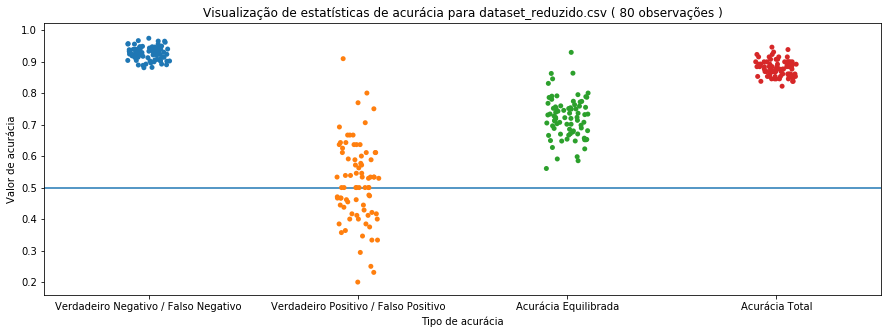

In [46]:
lst = [{"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.23076923076923078, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.585212201591512}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9203539823008849, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7726769911504425}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8956521739130435, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6978260869565218}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9145299145299145, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7072649572649572}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7359649122807017}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9344262295081968, "Acur\u00e1cia 2": 0.8571428571428571, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8957845433255269}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9130434782608695, "Acur\u00e1cia 2": 0.42857142857142855, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.670807453416149}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.746583850931677}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9572649572649573, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.811965811965812}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.911504424778761, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7370022123893805}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7261273209549072}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9047619047619048, "Acur\u00e1cia 2": 0.4583333333333333, "Acur\u00e1cia Total": 0.8217, "Acur\u00e1cia Equilibrada": 0.6815476190476191}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7584033613445378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.963963963963964, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7319819819819819}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9401709401709402, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8450854700854701}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.918918918918919, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7927927927927928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9663865546218487, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7331932773109244}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7195652173913043}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.954954954954955, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8108108108108107}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7785285285285286}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6621352785145889}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9416666666666667, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8041666666666667}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9649122807017544, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7491228070175439}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9375, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7334558823529411}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8898305084745762, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7630970724191063}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6228070175438596}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8991596638655462, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7495798319327731}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9473684210526315, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7070175438596491}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9576271186440678, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7515408320493067}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8888888888888888, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6527777777777778}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9351851851851852, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7533068783068784}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.722972972972973}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9, "Acur\u00e1cia 2": 0.47368421052631576, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6868421052631579}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9327731092436975, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.6663865546218488}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9473684210526315, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8070175438596491}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7502765486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9130434782608695, "Acur\u00e1cia 2": 0.21428571428571427, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.5636645962732919}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7390583554376657}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7800462249614792}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.42105263157894735, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.687799043062201}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6906906906906907}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9238095238095239, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.8295, "Acur\u00e1cia Equilibrada": 0.6702380952380953}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9051724137931034, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.721816976127321}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9469026548672567, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7547013274336283}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9819819819819819, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7965465465465466}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9732142857142857, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7219012605042017}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8306197478991597}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7271929824561403}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9557522123893806, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7278761061946903}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.722972972972973}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.631578947368421, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7930622009569378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9401709401709402, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7617521367521367}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9173553719008265, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7711776859504132}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9098360655737705, "Acur\u00e1cia 2": 0.2857142857142857, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.5977751756440282}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7842835130970724}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9411764705882353, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7705882352941176}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.746583850931677}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9181818181818182, "Acur\u00e1cia 2": 0.42105263157894735, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6696172248803828}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9655172413793104, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7519893899204244}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9565217391304348, "Acur\u00e1cia 2": 0.7142857142857143, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8354037267080745}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8879310344827587, "Acur\u00e1cia 2": 0.6923076923076923, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7901193633952255}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9491525423728814, "Acur\u00e1cia 2": 0.9090909090909091, "Acur\u00e1cia Total": 0.9457, "Acur\u00e1cia Equilibrada": 0.9291217257318952}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8907563025210085, "Acur\u00e1cia 2": 0.8, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.8453781512605043}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.864, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6819999999999999}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.5789473684210527, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7667464114832536}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9180327868852459, "Acur\u00e1cia 2": 0.7142857142857143, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8161592505854801}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.954954954954955, "Acur\u00e1cia 2": 0.5555555555555556, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7552552552552553}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9304347826086956, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7866459627329192}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9469026548672567, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7859513274336283}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.6153846153846154, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7688992042440319}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8861788617886179, "Acur\u00e1cia 2": 0.16666666666666666, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.5264227642276423}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7948717948717949}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7815265486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8306197478991597}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.907563025210084, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.753781512605042}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9642857142857143, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.717436974789916}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9439252336448598, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7446898895497026}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6805555555555556}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.4117647058823529, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6567752100840336}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9568965517241379, "Acur\u00e1cia 2": 0.6153846153846154, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7861405835543767}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9663865546218487, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.9457, "Acur\u00e1cia Equilibrada": 0.8331932773109243}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.6923076923076923, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.8073607427055702}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9181818181818182, "Acur\u00e1cia 2": 0.47368421052631576, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.695933014354067}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6919761273209549}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.4375, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6877765486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9363636363636364, "Acur\u00e1cia 2": 0.7368421052631579, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8366028708133971}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6964285714285714}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9636363636363636, "Acur\u00e1cia 2": 0.5263157894736842, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.744976076555024}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.36363636363636365, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.647919876733436}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9428571428571428, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6797619047619048}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9196428571428571, "Acur\u00e1cia 2": 0.6470588235294118, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7833508403361344}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7184684684684685}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.35714285714285715, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6394409937888199}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7388289676425269}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.941747572815534, "Acur\u00e1cia 2": 0.5769230769230769, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7593353248693054}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.8571428571428571, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8981366459627329}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8813559322033898, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7134052388289676}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.957983193277311, "Acur\u00e1cia 2": 0.3, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.6289915966386554}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9711538461538461, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7855769230769231}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7423844537815126}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7359649122807017}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9304347826086956, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7509316770186335}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7450105042016807}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9067796610169492, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7715716486902928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.2, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.5605263157894737}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9292035398230089, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7771017699115044}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6517543859649123}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9557522123893806, "Acur\u00e1cia 2": 0.8125, "Acur\u00e1cia Total": 0.938, "Acur\u00e1cia Equilibrada": 0.8841261061946903}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9243697478991597, "Acur\u00e1cia 2": 0.8, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8621848739495799}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9586776859504132, "Acur\u00e1cia 2": 0.375, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.6668388429752066}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9316239316239316, "Acur\u00e1cia 2": 0.25, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.5908119658119658}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7026315789473685}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9193548387096774, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.6596774193548387}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9586776859504132, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7293388429752066}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8974358974358975, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.657051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6492042440318303}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9464285714285714, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7379201680672269}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9487179487179487, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.766025641025641}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.45454545454545453, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6891371340523883}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9724770642201835, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7612385321100918}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9203539823008849, "Acur\u00e1cia 2": 0.375, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6476769911504425}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6876657824933687}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7345916795069337}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.774024024024024}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6951951951951951}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6964285714285714}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6271929824561403}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9743589743589743, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9535, "Acur\u00e1cia Equilibrada": 0.8621794871794872}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8771929824561403, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8295, "Acur\u00e1cia Equilibrada": 0.6719298245614035}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9739130434782609, "Acur\u00e1cia 2": 0.35714285714285715, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.665527950310559}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8918918918918919, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7515015015015015}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9333333333333333, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9357798165137615, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6678899082568808}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8974358974358975, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.782051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7129726890756303}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9067796610169492, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7715716486902928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9259259259259259, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.701058201058201}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8771929824561403, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7719298245614035}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8803418803418803, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7735042735042734}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9083333333333333, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6763888888888889}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9351851851851852, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7056878306878307}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.940677966101695, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7885208012326657}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.956140350877193, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7780701754385965}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.944954128440367, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7224770642201834}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9026548672566371, "Acur\u00e1cia 2": 0.6875, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7950774336283186}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9568965517241379, "Acur\u00e1cia 2": 0.7692307692307693, "Acur\u00e1cia Total": 0.938, "Acur\u00e1cia Equilibrada": 0.8630636604774535}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9310344827586207, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6962864721485411}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.4117647058823529, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6701680672268908}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9646017699115044, "Acur\u00e1cia 2": 0.4375, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7010508849557522}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8898305084745762, "Acur\u00e1cia 2": 0.8181818181818182, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.8540061633281972}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9541284403669725, "Acur\u00e1cia 2": 0.45, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7020642201834862}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.29411764705882354, "Acur\u00e1cia Total": 0.8217, "Acur\u00e1cia Equilibrada": 0.5979516806722689}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.944954128440367, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7474770642201836}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6396396396396397}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9279279279279279, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7139639639639639}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7115384615384616}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8918918918918919, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7515015015015015}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.42857142857142855, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6751552795031056}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9292035398230089, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7146017699115044}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.918918918918919, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7094594594594594}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9243697478991597, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8121848739495798}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9439252336448598, "Acur\u00e1cia 2": 0.5909090909090909, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7674171622769754}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7584033613445378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7423844537815126}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9482758620689655, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7049071618037135}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7304376657824934}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7532051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9298245614035088, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7315789473684211}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9611650485436893, "Acur\u00e1cia 2": 0.34615384615384615, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6536594473487678}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9649122807017544, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7491228070175439}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9791666666666666, "Acur\u00e1cia 2": 0.45454545454545453, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.7168560606060606}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6850877192982456}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9375, "Acur\u00e1cia 2": 0.35294117647058826, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6452205882352942}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9174311926605505, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7337155963302753}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6517543859649123}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9541284403669725, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8270642201834862}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9421487603305785, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8460743801652892}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9009009009009009, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7560060060060061}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6535145888594165}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9196428571428571, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.8127626050420168}]
dataplot = pd.DataFrame(lst)
dataplot = dataplot[dataplot['arquivo']=='dataset_reduzido.csv']
dataplot = dataplot[['Acurácia 1', 'Acurácia 2', 'Acurácia Equilibrada', 'Acurácia Total']]
dataplot = dataplot.rename(columns={
    "Acurácia 1": "Verdadeiro Negativo / Falso Negativo",
    "Acurácia 2": "Verdadeiro Positivo / Falso Positivo"
})
dataplot = dataplot.melt()
ax = sns.stripplot(x='variable', y='value', data=dataplot)
ax.axhline(y=0.5)
ax.set_title('Visualização de estatísticas de acurácia para dataset_reduzido.csv ( 80 observações )')
ax.set(ylabel='Valor de acurácia')
ax.set(xlabel='Tipo de acurácia')
pass

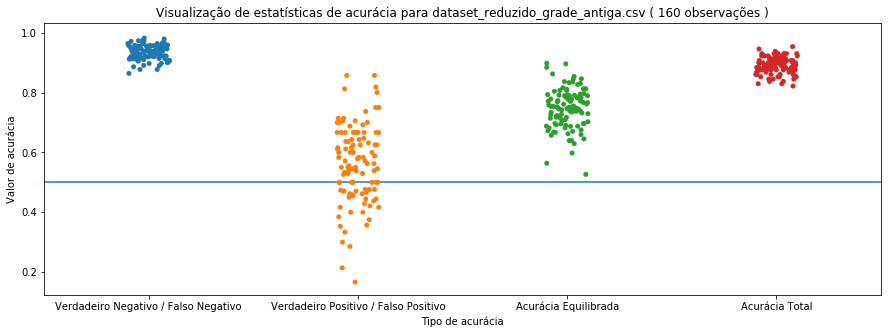

In [47]:
lst = [{"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.23076923076923078, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.585212201591512}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9203539823008849, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7726769911504425}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8956521739130435, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6978260869565218}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9145299145299145, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7072649572649572}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7359649122807017}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9344262295081968, "Acur\u00e1cia 2": 0.8571428571428571, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8957845433255269}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9130434782608695, "Acur\u00e1cia 2": 0.42857142857142855, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.670807453416149}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.746583850931677}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9572649572649573, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.811965811965812}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.911504424778761, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7370022123893805}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7261273209549072}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9047619047619048, "Acur\u00e1cia 2": 0.4583333333333333, "Acur\u00e1cia Total": 0.8217, "Acur\u00e1cia Equilibrada": 0.6815476190476191}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7584033613445378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.963963963963964, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7319819819819819}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9401709401709402, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8450854700854701}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.918918918918919, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7927927927927928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9663865546218487, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7331932773109244}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7195652173913043}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.954954954954955, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8108108108108107}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7785285285285286}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6621352785145889}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9416666666666667, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8041666666666667}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9649122807017544, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7491228070175439}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9375, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7334558823529411}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8898305084745762, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7630970724191063}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6228070175438596}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8991596638655462, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7495798319327731}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9473684210526315, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7070175438596491}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9576271186440678, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7515408320493067}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8888888888888888, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6527777777777778}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9351851851851852, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7533068783068784}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.722972972972973}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9, "Acur\u00e1cia 2": 0.47368421052631576, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6868421052631579}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9327731092436975, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.6663865546218488}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9473684210526315, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8070175438596491}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7502765486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9130434782608695, "Acur\u00e1cia 2": 0.21428571428571427, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.5636645962732919}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9396551724137931, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7390583554376657}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7800462249614792}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.42105263157894735, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.687799043062201}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6906906906906907}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9238095238095239, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.8295, "Acur\u00e1cia Equilibrada": 0.6702380952380953}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9051724137931034, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.721816976127321}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9469026548672567, "Acur\u00e1cia 2": 0.5625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7547013274336283}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9819819819819819, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7965465465465466}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9732142857142857, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7219012605042017}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8306197478991597}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7271929824561403}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9557522123893806, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7278761061946903}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.722972972972973}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.631578947368421, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7930622009569378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9401709401709402, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7617521367521367}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9173553719008265, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7711776859504132}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9098360655737705, "Acur\u00e1cia 2": 0.2857142857142857, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.5977751756440282}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7842835130970724}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9411764705882353, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7705882352941176}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.746583850931677}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9181818181818182, "Acur\u00e1cia 2": 0.42105263157894735, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6696172248803828}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9655172413793104, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7519893899204244}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9565217391304348, "Acur\u00e1cia 2": 0.7142857142857143, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8354037267080745}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8879310344827587, "Acur\u00e1cia 2": 0.6923076923076923, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7901193633952255}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9491525423728814, "Acur\u00e1cia 2": 0.9090909090909091, "Acur\u00e1cia Total": 0.9457, "Acur\u00e1cia Equilibrada": 0.9291217257318952}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8907563025210085, "Acur\u00e1cia 2": 0.8, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.8453781512605043}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.864, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6819999999999999}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9545454545454546, "Acur\u00e1cia 2": 0.5789473684210527, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7667464114832536}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9180327868852459, "Acur\u00e1cia 2": 0.7142857142857143, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8161592505854801}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.954954954954955, "Acur\u00e1cia 2": 0.5555555555555556, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7552552552552553}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9304347826086956, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7866459627329192}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9469026548672567, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7859513274336283}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.6153846153846154, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7688992042440319}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8861788617886179, "Acur\u00e1cia 2": 0.16666666666666666, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.5264227642276423}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7948717948717949}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7815265486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.8306197478991597}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.907563025210084, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.753781512605042}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9642857142857143, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.717436974789916}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9439252336448598, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7446898895497026}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6805555555555556}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.4117647058823529, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6567752100840336}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9568965517241379, "Acur\u00e1cia 2": 0.6153846153846154, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.7861405835543767}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9663865546218487, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.9457, "Acur\u00e1cia Equilibrada": 0.8331932773109243}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.6923076923076923, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.8073607427055702}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9181818181818182, "Acur\u00e1cia 2": 0.47368421052631576, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.695933014354067}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6919761273209549}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9380530973451328, "Acur\u00e1cia 2": 0.4375, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6877765486725664}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9363636363636364, "Acur\u00e1cia 2": 0.7368421052631579, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8366028708133971}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6964285714285714}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9636363636363636, "Acur\u00e1cia 2": 0.5263157894736842, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.744976076555024}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.36363636363636365, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.647919876733436}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9428571428571428, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6797619047619048}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9196428571428571, "Acur\u00e1cia 2": 0.6470588235294118, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7833508403361344}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7184684684684685}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.35714285714285715, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6394409937888199}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9322033898305084, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7388289676425269}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.941747572815534, "Acur\u00e1cia 2": 0.5769230769230769, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7593353248693054}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.8571428571428571, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8981366459627329}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8813559322033898, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7134052388289676}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.957983193277311, "Acur\u00e1cia 2": 0.3, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.6289915966386554}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9711538461538461, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7855769230769231}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7423844537815126}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7359649122807017}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9304347826086956, "Acur\u00e1cia 2": 0.5714285714285714, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7509316770186335}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7450105042016807}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9067796610169492, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7715716486902928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.2, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.5605263157894737}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9292035398230089, "Acur\u00e1cia 2": 0.625, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7771017699115044}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6517543859649123}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9557522123893806, "Acur\u00e1cia 2": 0.8125, "Acur\u00e1cia Total": 0.938, "Acur\u00e1cia Equilibrada": 0.8841261061946903}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9243697478991597, "Acur\u00e1cia 2": 0.8, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8621848739495799}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9586776859504132, "Acur\u00e1cia 2": 0.375, "Acur\u00e1cia Total": 0.9225, "Acur\u00e1cia Equilibrada": 0.6668388429752066}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9316239316239316, "Acur\u00e1cia 2": 0.25, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.5908119658119658}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9385964912280702, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7026315789473685}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9193548387096774, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.6596774193548387}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9586776859504132, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.7293388429752066}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8974358974358975, "Acur\u00e1cia 2": 0.4166666666666667, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.657051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6492042440318303}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9464285714285714, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7379201680672269}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9487179487179487, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.766025641025641}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.45454545454545453, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6891371340523883}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9724770642201835, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7612385321100918}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9203539823008849, "Acur\u00e1cia 2": 0.375, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6476769911504425}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9137931034482759, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6876657824933687}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.923728813559322, "Acur\u00e1cia 2": 0.5454545454545454, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7345916795069337}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9369369369369369, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.774024024024024}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6951951951951951}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9166666666666666, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6964285714285714}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9210526315789473, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6271929824561403}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9743589743589743, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9535, "Acur\u00e1cia Equilibrada": 0.8621794871794872}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8771929824561403, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8295, "Acur\u00e1cia Equilibrada": 0.6719298245614035}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9739130434782609, "Acur\u00e1cia 2": 0.35714285714285715, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.665527950310559}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8918918918918919, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7515015015015015}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9333333333333333, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9357798165137615, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6678899082568808}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8974358974358975, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.782051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.47058823529411764, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7129726890756303}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9067796610169492, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7715716486902928}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9259259259259259, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.701058201058201}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8771929824561403, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7719298245614035}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8803418803418803, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7735042735042734}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9083333333333333, "Acur\u00e1cia 2": 0.4444444444444444, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.6763888888888889}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9351851851851852, "Acur\u00e1cia 2": 0.47619047619047616, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7056878306878307}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.940677966101695, "Acur\u00e1cia 2": 0.6363636363636364, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7885208012326657}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.956140350877193, "Acur\u00e1cia 2": 0.6, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7780701754385965}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.944954128440367, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7224770642201834}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9026548672566371, "Acur\u00e1cia 2": 0.6875, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7950774336283186}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9568965517241379, "Acur\u00e1cia 2": 0.7692307692307693, "Acur\u00e1cia Total": 0.938, "Acur\u00e1cia Equilibrada": 0.8630636604774535}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9310344827586207, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.6962864721485411}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.4117647058823529, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6701680672268908}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9646017699115044, "Acur\u00e1cia 2": 0.4375, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7010508849557522}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.8898305084745762, "Acur\u00e1cia 2": 0.8181818181818182, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.8540061633281972}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9541284403669725, "Acur\u00e1cia 2": 0.45, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7020642201834862}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9017857142857143, "Acur\u00e1cia 2": 0.29411764705882354, "Acur\u00e1cia Total": 0.8217, "Acur\u00e1cia Equilibrada": 0.5979516806722689}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.944954128440367, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7474770642201836}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9459459459459459, "Acur\u00e1cia 2": 0.3333333333333333, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6396396396396397}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9122807017543859, "Acur\u00e1cia 2": 0.6666666666666666, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7894736842105263}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9279279279279279, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.7139639639639639}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7115384615384616}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.8918918918918919, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.7515015015015015}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9217391304347826, "Acur\u00e1cia 2": 0.42857142857142855, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6751552795031056}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9292035398230089, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.876, "Acur\u00e1cia Equilibrada": 0.7146017699115044}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.918918918918919, "Acur\u00e1cia 2": 0.5, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7094594594594594}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9243697478991597, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.8121848739495798}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9439252336448598, "Acur\u00e1cia 2": 0.5909090909090909, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7674171622769754}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9285714285714286, "Acur\u00e1cia 2": 0.5882352941176471, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7584033613445378}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9553571428571429, "Acur\u00e1cia 2": 0.5294117647058824, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7423844537815126}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9482758620689655, "Acur\u00e1cia 2": 0.46153846153846156, "Acur\u00e1cia Total": 0.8992, "Acur\u00e1cia Equilibrada": 0.7049071618037135}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.5384615384615384, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7304376657824934}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9230769230769231, "Acur\u00e1cia 2": 0.5833333333333334, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.7532051282051282}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9298245614035088, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.8837, "Acur\u00e1cia Equilibrada": 0.7315789473684211}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9611650485436893, "Acur\u00e1cia 2": 0.34615384615384615, "Acur\u00e1cia Total": 0.8372, "Acur\u00e1cia Equilibrada": 0.6536594473487678}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9649122807017544, "Acur\u00e1cia 2": 0.5333333333333333, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.7491228070175439}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9791666666666666, "Acur\u00e1cia 2": 0.45454545454545453, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.7168560606060606}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4666666666666667, "Acur\u00e1cia Total": 0.8527, "Acur\u00e1cia Equilibrada": 0.6850877192982456}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9375, "Acur\u00e1cia 2": 0.35294117647058826, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.6452205882352942}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9174311926605505, "Acur\u00e1cia 2": 0.55, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7337155963302753}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9035087719298246, "Acur\u00e1cia 2": 0.4, "Acur\u00e1cia Total": 0.845, "Acur\u00e1cia Equilibrada": 0.6517543859649123}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9541284403669725, "Acur\u00e1cia 2": 0.7, "Acur\u00e1cia Total": 0.9147, "Acur\u00e1cia Equilibrada": 0.8270642201834862}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9421487603305785, "Acur\u00e1cia 2": 0.75, "Acur\u00e1cia Total": 0.9302, "Acur\u00e1cia Equilibrada": 0.8460743801652892}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9009009009009009, "Acur\u00e1cia 2": 0.6111111111111112, "Acur\u00e1cia Total": 0.8605, "Acur\u00e1cia Equilibrada": 0.7560060060060061}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9391304347826087, "Acur\u00e1cia 2": 0.6428571428571429, "Acur\u00e1cia Total": 0.907, "Acur\u00e1cia Equilibrada": 0.7909937888198758}, {"arquivo": "dataset_reduzido.csv", "Acur\u00e1cia 1": 0.9224137931034483, "Acur\u00e1cia 2": 0.38461538461538464, "Acur\u00e1cia Total": 0.8682, "Acur\u00e1cia Equilibrada": 0.6535145888594165}, {"arquivo": "dataset_reduzido_grade_antiga.csv", "Acur\u00e1cia 1": 0.9196428571428571, "Acur\u00e1cia 2": 0.7058823529411765, "Acur\u00e1cia Total": 0.8915, "Acur\u00e1cia Equilibrada": 0.8127626050420168}]
dataplot = pd.DataFrame(lst)
dataplot = dataplot[dataplot['arquivo']=='dataset_reduzido_grade_antiga.csv']
dataplot = dataplot[['Acurácia 1', 'Acurácia 2', 'Acurácia Equilibrada', 'Acurácia Total']]
dataplot = dataplot.rename(columns={
    "Acurácia 1": "Verdadeiro Negativo / Falso Negativo",
    "Acurácia 2": "Verdadeiro Positivo / Falso Positivo"
})
dataplot = dataplot.melt()
ax = sns.stripplot(x='variable', y='value', data=dataplot)
ax.axhline(y=0.5)
ax.set_title('Visualização de estatísticas de acurácia para dataset_reduzido_grade_antiga.csv ( 160 observações )')
ax.set(ylabel='Valor de acurácia')
ax.set(xlabel='Tipo de acurácia')
pass